In [1]:
import pickle
import numpy as np

features_min, features_max = np.load("norm_constants.npy",allow_pickle=True).tolist()

with open('cluster_year.pkl', 'rb') as f:
    cluster_year = pickle.load(f)

with open('name_encoder.pkl', 'rb') as f:
    le = pickle.load(f)


# ARIMA

In [2]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series
from sktime.utils.dependencies import _check_soft_dependencies
import warnings
from sktime.forecasting.arima import AutoARIMA
from sklearn.metrics import mean_squared_error
import pandas as pd

warnings.filterwarnings("ignore") 

years2concat = {}
for c, y in cluster_year:
    if c not in years2concat:
         years2concat[c] = []    
    years2concat[c].append(y)


y_pred = []
y_true = []

for c, y in cluster_year:
    for j,k in cluster_year[c,y][1]:
        targs = cluster_year[c,y][1][j,k][1]
        datas = cluster_year[c,y][1][j,k][0][:,0]
        datas2 = cluster_year[c,y][1][j,k][0][:,2]

        ys = pd.Series(targs[:4].flatten())
        y_ = pd.Series(targs.flatten())
        xst = pd.DataFrame(datas2[:4].reshape(-1,1),index=ys.index)    


        xs = pd.DataFrame(datas2.reshape(-1,1),index=y_.index)  
        #print(xs)

        amodel = AutoARIMA(suppress_warnings=True,start_p=2,start_q=2,seasonal=False,maxiter=500).fit(ys,X=xst)

        y_p = amodel.predict(fh=np.asarray([1]),X=xs)
       
        y_pred.append(float(y_p)) #, batch_size=batch_size)
        #print(targs,y_pred[len(y_pred) - 1])

        y_true.append(targs[4])
        #break



In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

r2 = r2_score(np.asarray(y_pred).flatten(),np.asarray(y_true).flatten())    
print("r2: ",r2)

mae = mean_absolute_error(np.asarray(y_pred).flatten() * features_max[0],np.asarray(y_true).flatten() * features_max[0])
print("mae: ",mae)

mse = mean_squared_error(np.asarray(y_pred).flatten() * features_max[0],np.asarray(y_true).flatten() * features_max[0])
print("mse: ",mse)

r2:  0.7195369929114069
mae:  184639931.85786268
mse:  2.1436493467374224e+17


## LSTM/GRU

In [2]:

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


def printf(*args, fname="log.txt"):
    with open(os.path.join("test_outputs",fname),"a+") as f:
        for a in args:
            f.write(str(a) + " ")
        f.write("\n") 
    print(args) 

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import tensorflow as tf

import optuna
import os

2025-08-23 01:34:21.114840: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755902061.527804  839447 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755902061.696674  839447 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755902064.428662  839447 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755902064.428699  839447 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755902064.428700  839447 computation_placer.cc:177] computation placer alr

In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tkan import TKAN
from tensorflow.keras.models import load_model
from tensorflow.keras import ops
from tensorflow.keras import Loss
from tensorflow import keras
#np.bool = np.bool_

from sklearn.model_selection import KFold
#xgb.set_config(verbosity=2)
targs = []
datas = []

for c, y in cluster_year:
    for j,k in cluster_year[c,y][1]:
        targs += [cluster_year[c,y][1][j,k][1]]
        datas += [cluster_year[c,y][1][j,k][0]]

X = np.vstack(datas).reshape(-1,5,4)
y = np.vstack(targs)

X_train, X_test, ynn_train,ynn_test = train_test_split(X,y,test_size = 0.33)

def make_modelLSTM(input_shape, hidden_size, dropout):
    input_layer = tf.keras.layers.Input(input_shape)
    #dim = tf.zeros([batch_size,hidden_size])  
    output_layer = tf.keras.layers.LSTM(hidden_size, kernel_regularizer=regularizers.L2(0.001),return_sequences=True,dropout=dropout)(input_layer)#, initial_state=[dim, dim])
    output_layer2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='tanh'))(output_layer)    
    return tf.keras.models.Model(inputs=input_layer, outputs=output_layer2)
 
def make_GRU(input_shape, hidden_size, dropout):
    input_layer = tf.keras.layers.Input(input_shape)
    output_layer = tf.keras.layers.GRU(hidden_size, kernel_regularizer=regularizers.L2(0.001),return_sequences=True,dropout=dropout)(input_layer)#, initial_state=[dim, dim])
    output_layer2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='tanh'))(output_layer)    
    return tf.keras.models.Model(inputs=input_layer, outputs=output_layer2)

def make_modelTKAN(input_shape, hidden_size, dropout):
    model = tf.keras.Sequential([
          tf.keras.layers.InputLayer(input_shape=input_shape),
          TKAN(hidden_size, sub_kan_configs=[{'spline_order':3}], return_sequences=True, use_bias=True, kernel_regularizer=regularizers.L2(dropout),
    bias_regularizer=regularizers.L2(dropout), recurrent_regularizer=regularizers.L2(dropout)),
          tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='tanh')),
    ])
    return model

models = {"LSTM":make_modelLSTM, "GRU": make_GRU, "TKAN": make_modelTKAN}
#models = {"TKAN": make_modelTKAN}

for model_name in models:
    make_model = models[model_name]
    batch_size = 64       

    def objective(trial):
        lr = trial.suggest_float('lr', 0.00001, 0.01)
        hidden_size = trial.suggest_int('hs', 2, 32)

        if model_name == "TKAN":
            do = trial.suggest_float('dropout', 1e-5, 1e-2)
            ep = 50
        else:    
            do = trial.suggest_float('dropout', 0.05, 0.2)
            ep = 1000
            
        kf = KFold(n_splits=3)
        scores = []
        for _, (train_index, test_index) in enumerate(kf.split(X_train)):
            model = make_model(input_shape=X_train.shape[1:],hidden_size=hidden_size, dropout = do)
        # 
            opt = tf.keras.optimizers.Adam(learning_rate=lr)
            # callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
            #                                patience=10)

            checkpoint_filepath = 'checkpoint.keras'
            model_checkpoint_callback = ModelCheckpoint(
                filepath=checkpoint_filepath,
                save_best_only=True,
                monitor='loss',  # Or 'val_accuracy', or any other metric
                mode='min',  # Or 'max' if you are monitoring a metric to be maximized
            )
            
            reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                                          patience=10, min_lr=0.00001)        
            
            model.compile(
                 optimizer=opt,
                 loss='binary_crossentropy',
                 metrics=["mean_squared_error"],
            )

            history = model.fit(
                 X_train[train_index],
                 ynn_train[train_index],
                 batch_size=batch_size,
                 epochs=ep,
                 verbose=0,callbacks=[model_checkpoint_callback, reduce_lr]
            )

            best_model = load_model(checkpoint_filepath)
            try:
                y_pred = best_model.predict(X_train[test_index]) #, batch_size=batch_size)
                scores.append(mean_squared_error(ynn_train[test_index].flatten(),y_pred.flatten()))
            except Exception as e:
                print(e)
                scores.append(1e26)
            del history
            del model    
        return np.asarray(scores).mean() 
        
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)    
    
    lr = study.best_trial.params["lr"]     
    hs = study.best_trial.params["hs"]     
    do = study.best_trial.params["dropout"]   

    model = make_model(input_shape=X_train.shape[1:],hidden_size=hs, dropout = do)
# 
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    #callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
    #                               patience=10)

    model.compile(
         optimizer=opt,
         loss='binary_crossentropy',
         metrics=["mean_squared_error"],
    )

    if model_name == "TKAN":
        ep = 50
    else:
        ep = 1000    

    checkpoint_filepath = 'checkpoint.keras'
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_best_only=True,
        monitor='loss',  # Or 'val_accuracy', or any other metric
        mode='min',  # Or 'max' if you are monitoring a metric to be maximized
    )

    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                                  patience=10, min_lr=0.00001)  
    
    history = model.fit(
         X_train,
         ynn_train,
         batch_size=batch_size,
         epochs=ep,
         verbose=0,callbacks=[model_checkpoint_callback, reduce_lr]
    )   
    model = load_model(checkpoint_filepath)   
    try:
        y_pred = model.predict(X_test) #, batch_size=batch_size)
        mse_score = mean_squared_error(ynn_test.flatten() * features_max[0],y_pred.flatten() * features_max[0])
        mae_score = mean_absolute_error(ynn_test.flatten() * features_max[0],y_pred.flatten() * features_max[0])
        r2_ = r2_score(ynn_test.flatten(),y_pred.flatten())
        printf(model_name,mse_score, mae_score, r2_,fname="baseline_output.txt")     
        #nn_data.append([model_name,mse_score, mae_score])
    except Exception as e:
        print(e)
    del model

[I 2025-08-23 01:34:37,990] A new study created in memory with name: no-name-23fb512d-d7dc-4037-9d7c-cae7aab592c4
2025-08-23 01:34:38.023664: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-08-23 01:36:26,400] Trial 0 finished with value: 0.004038883028835872 and parameters: {'lr': 0.0029634807873267117, 'hs': 15, 'dropout': 0.07762635886697528}. Best is trial 0 with value: 0.004038883028835872.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-08-23 01:38:08,368] Trial 1 finished with value: 0.00396357945969137 and parameters: {'lr': 0.003854664623415963, 'hs': 10, 'dropout': 0.15720289740269122}. Best is trial 1 with value: 0.00396357945969137.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-08-23 01:39:51,354] Trial 2 finished with value: 0.003472980355944764 and parameters: {'lr': 0.006018111108416738, 'hs': 15, 'dropout': 0.1211840352183779}. Best is trial 2 with value: 0.003472980355944764.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-08-23 01:41:37,801] Trial 3 finished with value: 0.0035388379573801734 and parameters: {'lr': 0.0069785289253990225, 'hs': 12, 'dropout': 0.1841922704500597}. Best is trial 2 with value: 0.003472980355944764.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-08-23 01:43:19,840] Trial 4 finished with value: 0.0028803733459704943 and parameters: {'lr': 0.006704605528343786, 'hs': 11, 'dropout': 0.07977019553951972}. Best is trial 4 with value: 0.0028803733459704943.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2025-08-23 01:45:04,048] Trial 5 finished with value: 0.01527754641573876 and parameters: {'lr': 0.0043817567276726995, 'hs': 24, 'dropout': 0.10859848521078325}. Best is trial 4 with value: 0.0028803733459704943.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-08-23 01:46:47,486] Trial 6 finished with value: 0.003932555831988046 and parameters: {'lr': 0.0005557593185338077, 'hs': 21, 'dropout': 0.1093695372177871}. Best is trial 4 with value: 0.0028803733459704943.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-08-23 01:48:30,805] Trial 7 finished with value: 0.003922756308685229 and parameters: {'lr': 0.00741485652569045, 'hs': 18, 'dropout': 0.14995382896849035}. Best is trial 4 with value: 0.0028803733459704943.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-08-23 01:50:14,910] Trial 8 finished with value: 0.00313246176425376 and parameters: {'lr': 0.003185825771476618, 'hs': 28, 'dropout': 0.12635046350405726}. Best is trial 4 with value: 0.0028803733459704943.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-08-23 01:51:55,628] Trial 9 finished with value: 0.0034962213726408703 and parameters: {'lr': 0.002867040712687, 'hs': 12, 'dropout': 0.1414753785474604}. Best is trial 4 with value: 0.0028803733459704943.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-08-23 01:53:38,462] Trial 10 finished with value: 0.0026996922440768946 and parameters: {'lr': 0.009656550670523362, 'hs': 2, 'dropout': 0.053153100998522024}. Best is trial 10 with value: 0.0026996922440768946.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-08-23 01:55:19,637] Trial 11 finished with value: 0.0030898630846630287 and parameters: {'lr': 0.009610988711718574, 'hs': 2, 'dropout': 0.054516334426083966}. Best is trial 10 with value: 0.0026996922440768946.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-08-23 01:57:00,802] Trial 12 finished with value: 0.002683137013098816 and parameters: {'lr': 0.009959164576252755, 'hs': 3, 'dropout': 0.05324362823328643}. Best is trial 12 with value: 0.002683137013098816.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-08-23 01:58:42,689] Trial 13 finished with value: 0.0038661446017320814 and parameters: {'lr': 0.009882598194395239, 'hs': 2, 'dropout': 0.05274145440175414}. Best is trial 12 with value: 0.002683137013098816.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-08-23 02:00:22,726] Trial 14 finished with value: 0.0027691844052366264 and parameters: {'lr': 0.008685925308028492, 'hs': 6, 'dropout': 0.08186735217970376}. Best is trial 12 with value: 0.002683137013098816.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-08-23 02:02:03,272] Trial 15 finished with value: 0.0031499299915309395 and parameters: {'lr': 0.008393221737165798, 'hs': 6, 'dropout': 0.06672351908797494}. Best is trial 12 with value: 0.002683137013098816.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2025-08-23 02:03:48,928] Trial 16 finished with value: 0.003658325146440608 and parameters: {'lr': 0.008382445606465293, 'hs': 6, 'dropout': 0.09827371646986394}. Best is trial 12 with value: 0.002683137013098816.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-08-23 02:05:35,172] Trial 17 finished with value: 0.003187659056664903 and parameters: {'lr': 0.009964456188229474, 'hs': 32, 'dropout': 0.19759933271296595}. Best is trial 12 with value: 0.002683137013098816.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-08-23 02:07:16,754] Trial 18 finished with value: 0.0033371340844390667 and parameters: {'lr': 0.005463071601425636, 'hs': 8, 'dropout': 0.09129137704597239}. Best is trial 12 with value: 0.002683137013098816.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-08-23 02:08:57,836] Trial 19 finished with value: 0.017305093631628604 and parameters: {'lr': 0.0012765088237117802, 'hs': 2, 'dropout': 0.06081824816842985}. Best is trial 12 with value: 0.002683137013098816.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2025-08-23 02:10:38,057] Trial 20 finished with value: 0.0029419211770008707 and parameters: {'lr': 0.007967329457605081, 'hs': 4, 'dropout': 0.06855320567409201}. Best is trial 12 with value: 0.002683137013098816.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-08-23 02:12:21,906] Trial 21 finished with value: 0.002925187209491753 and parameters: {'lr': 0.00891533576430345, 'hs': 6, 'dropout': 0.08398895167968101}. Best is trial 12 with value: 0.002683137013098816.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-08-23 02:14:03,179] Trial 22 finished with value: 0.0028734666244764977 and parameters: {'lr': 0.009012123406410895, 'hs': 5, 'dropout': 0.07194796698912093}. Best is trial 12 with value: 0.002683137013098816.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-08-23 02:15:43,907] Trial 23 finished with value: 0.004062677196421512 and parameters: {'lr': 0.009072699433034969, 'hs': 9, 'dropout': 0.06009051538516512}. Best is trial 12 with value: 0.002683137013098816.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2025-08-23 02:17:24,393] Trial 24 finished with value: 0.0034713181953152004 and parameters: {'lr': 0.007827977706967434, 'hs': 4, 'dropout': 0.09530910511619717}. Best is trial 12 with value: 0.002683137013098816.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2025-08-23 02:19:10,833] Trial 25 finished with value: 0.0027088245429637598 and parameters: {'lr': 0.006305987947355924, 'hs': 8, 'dropout': 0.05024340279194779}. Best is trial 12 with value: 0.002683137013098816.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-08-23 02:20:54,307] Trial 26 finished with value: 0.0027583335891912266 and parameters: {'lr': 0.005921083606996993, 'hs': 8, 'dropout': 0.05667734373476391}. Best is trial 12 with value: 0.002683137013098816.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2025-08-23 02:22:35,241] Trial 27 finished with value: 0.0031797470655230095 and parameters: {'lr': 0.006696645725595595, 'hs': 2, 'dropout': 0.0501642025010307}. Best is trial 12 with value: 0.002683137013098816.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2025-08-23 02:24:16,870] Trial 28 finished with value: 0.0036925869279478825 and parameters: {'lr': 0.00170379275571794, 'hs': 13, 'dropout': 0.07120129642205802}. Best is trial 12 with value: 0.002683137013098816.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2025-08-23 02:25:58,884] Trial 29 finished with value: 0.0032143576100236286 and parameters: {'lr': 0.004867393527351366, 'hs': 15, 'dropout': 0.050231604575455155}. Best is trial 12 with value: 0.002683137013098816.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2025-08-23 02:27:40,609] Trial 30 finished with value: 0.002366750230067776 and parameters: {'lr': 0.009277888785614046, 'hs': 18, 'dropout': 0.07581532850137189}. Best is trial 30 with value: 0.002366750230067776.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-08-23 02:29:25,460] Trial 31 finished with value: 0.00316173758657236 and parameters: {'lr': 0.009437791162515372, 'hs': 19, 'dropout': 0.06468898454105053}. Best is trial 30 with value: 0.002366750230067776.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-08-23 02:31:10,841] Trial 32 finished with value: 0.003300554441102847 and parameters: {'lr': 0.008085291900507337, 'hs': 23, 'dropout': 0.07575980751293561}. Best is trial 30 with value: 0.002366750230067776.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-08-23 02:32:53,051] Trial 33 finished with value: 0.002805412753053197 and parameters: {'lr': 0.007410314234475517, 'hs': 15, 'dropout': 0.08781538429972993}. Best is trial 30 with value: 0.002366750230067776.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2025-08-23 02:34:35,312] Trial 34 finished with value: 0.002433236578767569 and parameters: {'lr': 0.009274461265580708, 'hs': 20, 'dropout': 0.06240959687109613}. Best is trial 30 with value: 0.002366750230067776.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2025-08-23 02:36:17,552] Trial 35 finished with value: 0.0030481332468648907 and parameters: {'lr': 0.009353245890007375, 'hs': 21, 'dropout': 0.1698456056749061}. Best is trial 30 with value: 0.002366750230067776.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-08-23 02:38:00,605] Trial 36 finished with value: 0.0035131173066276643 and parameters: {'lr': 0.009891378294638086, 'hs': 25, 'dropout': 0.10228471901342917}. Best is trial 30 with value: 0.002366750230067776.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2025-08-23 02:39:43,295] Trial 37 finished with value: 0.00310981991526397 and parameters: {'lr': 0.008623902196904223, 'hs': 20, 'dropout': 0.07703337557147823}. Best is trial 30 with value: 0.002366750230067776.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-08-23 02:41:28,360] Trial 38 finished with value: 0.0028856122152693107 and parameters: {'lr': 0.00931770473436452, 'hs': 17, 'dropout': 0.062174148308475036}. Best is trial 30 with value: 0.002366750230067776.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-08-23 02:43:14,256] Trial 39 finished with value: 0.0029202177838578785 and parameters: {'lr': 0.007391944336617629, 'hs': 26, 'dropout': 0.12872840682387426}. Best is trial 30 with value: 0.002366750230067776.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2025-08-23 02:44:56,187] Trial 40 finished with value: 0.0028140308945960786 and parameters: {'lr': 0.007675024555835576, 'hs': 16, 'dropout': 0.11547662447867794}. Best is trial 30 with value: 0.002366750230067776.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2025-08-23 02:46:39,298] Trial 41 finished with value: 0.003852835062038261 and parameters: {'lr': 0.0038197550254326362, 'hs': 22, 'dropout': 0.06031378932246783}. Best is trial 30 with value: 0.002366750230067776.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2025-08-23 02:48:20,445] Trial 42 finished with value: 0.003009467499439991 and parameters: {'lr': 0.006460416444552836, 'hs': 13, 'dropout': 0.06864419416351993}. Best is trial 30 with value: 0.002366750230067776.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2025-08-23 02:50:01,487] Trial 43 finished with value: 0.0029869818111636 and parameters: {'lr': 0.009453463178806295, 'hs': 10, 'dropout': 0.05530483287868311}. Best is trial 30 with value: 0.002366750230067776.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2025-08-23 02:51:43,271] Trial 44 finished with value: 0.0031842942110083526 and parameters: {'lr': 0.008361095855031272, 'hs': 18, 'dropout': 0.07757098521066384}. Best is trial 30 with value: 0.002366750230067776.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2025-08-23 02:53:23,159] Trial 45 finished with value: 0.0033035704923804325 and parameters: {'lr': 0.00709722363067272, 'hs': 3, 'dropout': 0.050764520567690145}. Best is trial 30 with value: 0.002366750230067776.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2025-08-23 02:55:13,707] Trial 46 finished with value: 0.003152597580166733 and parameters: {'lr': 0.009994088901324335, 'hs': 4, 'dropout': 0.06325085168157693}. Best is trial 30 with value: 0.002366750230067776.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-08-23 02:56:57,002] Trial 47 finished with value: 0.003263417387312936 and parameters: {'lr': 0.008906742513286645, 'hs': 7, 'dropout': 0.08282316553604538}. Best is trial 30 with value: 0.002366750230067776.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2025-08-23 02:58:39,361] Trial 48 finished with value: 0.003762918876579442 and parameters: {'lr': 0.006160120604097364, 'hs': 11, 'dropout': 0.07095907873573995}. Best is trial 30 with value: 0.002366750230067776.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2025-08-23 03:00:21,434] Trial 49 finished with value: 0.00304209641280985 and parameters: {'lr': 0.0044825893367451495, 'hs': 14, 'dropout': 0.05846800395316108}. Best is trial 30 with value: 0.002366750230067776.


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-08-23 03:00:59,612] A new study created in memory with name: no-name-16756a09-7040-4598-a2d8-5369cce77900


('LSTM', 2.004686746705462e+17, 209366070.83469126, 0.7129404552658196)
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2025-08-23 03:02:42,504] Trial 0 finished with value: 0.004117946819391254 and parameters: {'lr': 0.008993665390720204, 'hs': 2, 'dropout': 0.1674274693906031}. Best is trial 0 with value: 0.004117946819391254.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-08-23 03:04:28,374] Trial 1 finished with value: 0.0034778911306976488 and parameters: {'lr': 0.009765510244978277, 'hs': 31, 'dropout': 0.17005257094494688}. Best is trial 1 with value: 0.0034778911306976488.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-08-23 03:06:15,209] Trial 2 finished with value: 0.003852291997975887 and parameters: {'lr': 0.0004029088501147607, 'hs': 25, 'dropout': 0.16517859656886735}. Best is trial 1 with value: 0.0034778911306976488.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2025-08-23 03:07:58,124] Trial 3 finished with value: 0.002592003257189671 and parameters: {'lr': 0.006178423208933401, 'hs': 9, 'dropout': 0.10375620636193218}. Best is trial 3 with value: 0.002592003257189671.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-08-23 03:09:43,097] Trial 4 finished with value: 0.0037035012273082986 and parameters: {'lr': 0.0004490840320001441, 'hs': 21, 'dropout': 0.18229068340455884}. Best is trial 3 with value: 0.002592003257189671.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-08-23 03:11:34,488] Trial 5 finished with value: 0.002687786719466512 and parameters: {'lr': 0.006468821494353144, 'hs': 16, 'dropout': 0.13950643695214462}. Best is trial 3 with value: 0.002592003257189671.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-08-23 03:13:21,397] Trial 6 finished with value: 0.0026060316248839744 and parameters: {'lr': 0.008247952535362304, 'hs': 17, 'dropout': 0.07216402556820584}. Best is trial 3 with value: 0.002592003257189671.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-08-23 03:15:09,785] Trial 7 finished with value: 0.002756925619203073 and parameters: {'lr': 0.0005244704073927885, 'hs': 30, 'dropout': 0.05456904296004411}. Best is trial 3 with value: 0.002592003257189671.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-08-23 03:16:56,583] Trial 8 finished with value: 0.004737547707858433 and parameters: {'lr': 0.0002953639044581962, 'hs': 31, 'dropout': 0.19056637592531622}. Best is trial 3 with value: 0.002592003257189671.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2025-08-23 03:18:41,166] Trial 9 finished with value: 0.0034706769065885688 and parameters: {'lr': 0.0081674879718857, 'hs': 22, 'dropout': 0.062362022875788}. Best is trial 3 with value: 0.002592003257189671.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2025-08-23 03:20:24,760] Trial 10 finished with value: 0.0033021291361604844 and parameters: {'lr': 0.003545828866759017, 'hs': 8, 'dropout': 0.10164924307143516}. Best is trial 3 with value: 0.002592003257189671.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-08-23 03:22:08,406] Trial 11 finished with value: 0.003594295796785947 and parameters: {'lr': 0.00590065727447706, 'hs': 13, 'dropout': 0.09405221342566114}. Best is trial 3 with value: 0.002592003257189671.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-08-23 03:23:51,866] Trial 12 finished with value: 0.0026261477860359352 and parameters: {'lr': 0.007413004793027719, 'hs': 11, 'dropout': 0.08667614397672965}. Best is trial 3 with value: 0.002592003257189671.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-08-23 03:25:36,615] Trial 13 finished with value: 0.011113935786854644 and parameters: {'lr': 0.003613572546123831, 'hs': 6, 'dropout': 0.12499930914541775}. Best is trial 3 with value: 0.002592003257189671.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2025-08-23 03:27:21,190] Trial 14 finished with value: 0.002835664427023847 and parameters: {'lr': 0.00492460402249624, 'hs': 18, 'dropout': 0.07422563288927206}. Best is trial 3 with value: 0.002592003257189671.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


[I 2025-08-23 03:29:13,421] Trial 15 finished with value: 0.0028633856544886004 and parameters: {'lr': 0.007549072918302561, 'hs': 13, 'dropout': 0.11971378952795779}. Best is trial 3 with value: 0.002592003257189671.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-08-23 03:31:00,859] Trial 16 finished with value: 0.004520539419625247 and parameters: {'lr': 0.004399154017162127, 'hs': 2, 'dropout': 0.10873871882574865}. Best is trial 3 with value: 0.002592003257189671.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-08-23 03:32:45,626] Trial 17 finished with value: 0.003134701463153496 and parameters: {'lr': 0.006215654955951147, 'hs': 7, 'dropout': 0.14144385008966195}. Best is trial 3 with value: 0.002592003257189671.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-08-23 03:34:30,352] Trial 18 finished with value: 0.0026031623928678056 and parameters: {'lr': 0.008576395445102808, 'hs': 17, 'dropout': 0.07912761421980091}. Best is trial 3 with value: 0.002592003257189671.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-08-23 03:36:13,844] Trial 19 finished with value: 0.0026391714714779422 and parameters: {'lr': 0.003014733559164149, 'hs': 10, 'dropout': 0.08525849594640625}. Best is trial 3 with value: 0.002592003257189671.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-08-23 03:37:59,186] Trial 20 finished with value: 0.0031214467477593245 and parameters: {'lr': 0.009398003269433934, 'hs': 26, 'dropout': 0.14407477659653978}. Best is trial 3 with value: 0.002592003257189671.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2025-08-23 03:39:43,460] Trial 21 finished with value: 0.0024119450797434466 and parameters: {'lr': 0.008249801934572185, 'hs': 16, 'dropout': 0.067827385149967}. Best is trial 21 with value: 0.0024119450797434466.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2025-08-23 03:41:27,880] Trial 22 finished with value: 0.0026465275635061225 and parameters: {'lr': 0.007148320460720331, 'hs': 15, 'dropout': 0.07234991086603776}. Best is trial 21 with value: 0.0024119450797434466.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-08-23 03:43:12,874] Trial 23 finished with value: 0.0024739039185303967 and parameters: {'lr': 0.008603952644971428, 'hs': 20, 'dropout': 0.05075065952891877}. Best is trial 21 with value: 0.0024119450797434466.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-08-23 03:44:58,144] Trial 24 finished with value: 0.002381295551695799 and parameters: {'lr': 0.005621382652594351, 'hs': 20, 'dropout': 0.05533960786454956}. Best is trial 24 with value: 0.002381295551695799.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2025-08-23 03:46:43,226] Trial 25 finished with value: 0.0026373442755126997 and parameters: {'lr': 0.009891453397926547, 'hs': 21, 'dropout': 0.051584680225595515}. Best is trial 24 with value: 0.002381295551695799.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


[I 2025-08-23 03:48:41,378] Trial 26 finished with value: 0.0025552657833253904 and parameters: {'lr': 0.001869856579311266, 'hs': 25, 'dropout': 0.06274917970941256}. Best is trial 24 with value: 0.002381295551695799.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-08-23 03:50:31,096] Trial 27 finished with value: 0.0028973669250188044 and parameters: {'lr': 0.007191541235256345, 'hs': 20, 'dropout': 0.05087093448967642}. Best is trial 24 with value: 0.002381295551695799.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-08-23 03:52:19,097] Trial 28 finished with value: 0.0023564263005222083 and parameters: {'lr': 0.005546679306137953, 'hs': 23, 'dropout': 0.06222871657803068}. Best is trial 28 with value: 0.0023564263005222083.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2025-08-23 03:54:06,105] Trial 29 finished with value: 0.003244026910374759 and parameters: {'lr': 0.005384774580314116, 'hs': 27, 'dropout': 0.06572748738277119}. Best is trial 28 with value: 0.0023564263005222083.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-08-23 03:55:51,618] Trial 30 finished with value: 0.002528291960895631 and parameters: {'lr': 0.004697831604963996, 'hs': 23, 'dropout': 0.09100931365001157}. Best is trial 28 with value: 0.0023564263005222083.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2025-08-23 03:57:37,134] Trial 31 finished with value: 0.002528549022504893 and parameters: {'lr': 0.006748098431373137, 'hs': 19, 'dropout': 0.06039672417164725}. Best is trial 28 with value: 0.0023564263005222083.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-08-23 03:59:23,488] Trial 32 finished with value: 0.0024829598679645434 and parameters: {'lr': 0.00893159594058773, 'hs': 28, 'dropout': 0.05061127449650425}. Best is trial 28 with value: 0.0023564263005222083.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-08-23 04:01:07,746] Trial 33 finished with value: 0.003573158598483663 and parameters: {'lr': 0.007897011228039758, 'hs': 14, 'dropout': 0.07936014955828423}. Best is trial 28 with value: 0.0023564263005222083.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-08-23 04:02:53,060] Trial 34 finished with value: 0.0030249565143984866 and parameters: {'lr': 0.0054794424776446644, 'hs': 23, 'dropout': 0.06693237012177622}. Best is trial 28 with value: 0.0023564263005222083.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-08-23 04:04:38,324] Trial 35 finished with value: 0.002828844907403577 and parameters: {'lr': 0.009141760007598487, 'hs': 24, 'dropout': 0.06024186669061582}. Best is trial 28 with value: 0.0023564263005222083.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2025-08-23 04:06:23,076] Trial 36 finished with value: 0.0034339081927676636 and parameters: {'lr': 0.0067324269598435125, 'hs': 20, 'dropout': 0.1587558816758066}. Best is trial 28 with value: 0.0023564263005222083.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2025-08-23 04:08:07,930] Trial 37 finished with value: 0.0027814417991007304 and parameters: {'lr': 0.004132998247250708, 'hs': 18, 'dropout': 0.07703880294543422}. Best is trial 28 with value: 0.0023564263005222083.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-08-23 04:09:54,141] Trial 38 finished with value: 0.002725117211993276 and parameters: {'lr': 0.0024952068369681057, 'hs': 29, 'dropout': 0.05838804943163657}. Best is trial 28 with value: 0.0023564263005222083.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-08-23 04:11:39,386] Trial 39 finished with value: 0.002477360206118405 and parameters: {'lr': 0.005693545166060282, 'hs': 22, 'dropout': 0.06911359804455147}. Best is trial 28 with value: 0.0023564263005222083.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-08-23 04:13:40,784] Trial 40 finished with value: 0.0031124486636778174 and parameters: {'lr': 0.007980699935046381, 'hs': 16, 'dropout': 0.11321600877879737}. Best is trial 28 with value: 0.0023564263005222083.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-08-23 04:15:32,093] Trial 41 finished with value: 0.0030357683451349656 and parameters: {'lr': 0.005990628255891397, 'hs': 22, 'dropout': 0.0682783400283229}. Best is trial 28 with value: 0.0023564263005222083.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


[I 2025-08-23 04:17:20,810] Trial 42 finished with value: 0.0027260370622844035 and parameters: {'lr': 0.005396489180235881, 'hs': 20, 'dropout': 0.09721596716158903}. Best is trial 28 with value: 0.0023564263005222083.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-08-23 04:19:08,877] Trial 43 finished with value: 0.0028710631281397615 and parameters: {'lr': 0.005611338804202219, 'hs': 25, 'dropout': 0.0844337680625471}. Best is trial 28 with value: 0.0023564263005222083.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-08-23 04:20:55,517] Trial 44 finished with value: 0.002846772732761835 and parameters: {'lr': 0.00878258850362865, 'hs': 22, 'dropout': 0.05545187641404269}. Best is trial 28 with value: 0.0023564263005222083.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-08-23 04:22:40,430] Trial 45 finished with value: 0.0027072778670399447 and parameters: {'lr': 0.006702872454831542, 'hs': 17, 'dropout': 0.06960291558472073}. Best is trial 28 with value: 0.0023564263005222083.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-08-23 04:24:25,945] Trial 46 finished with value: 0.002519957735686604 and parameters: {'lr': 0.004068441697152697, 'hs': 19, 'dropout': 0.0599539798750441}. Best is trial 28 with value: 0.0023564263005222083.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2025-08-23 04:26:11,029] Trial 47 finished with value: 0.003070692206481429 and parameters: {'lr': 0.008488587364514093, 'hs': 23, 'dropout': 0.1761789521224726}. Best is trial 28 with value: 0.0023564263005222083.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2025-08-23 04:27:56,466] Trial 48 finished with value: 0.0023826724718797715 and parameters: {'lr': 0.009395205835100895, 'hs': 21, 'dropout': 0.08037938462893557}. Best is trial 28 with value: 0.0023564263005222083.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2025-08-23 04:29:40,937] Trial 49 finished with value: 0.008521377354511408 and parameters: {'lr': 0.00949730963623401, 'hs': 15, 'dropout': 0.08117039745513145}. Best is trial 28 with value: 0.0023564263005222083.


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-08-23 04:30:20,800] A new study created in memory with name: no-name-d3b38acd-ecda-402e-8a79-8d0afea79f5f


('GRU', 1.1203288554854458e+17, 155687041.39681706, 0.8395753896133564)
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


[I 2025-08-23 04:30:42,981] Trial 0 finished with value: 0.006034536038549319 and parameters: {'lr': 0.0008304716512277068, 'hs': 18, 'dropout': 0.00040851360176610586}. Best is trial 0 with value: 0.006034536038549319.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


[I 2025-08-23 04:31:05,337] Trial 1 finished with value: 0.11910376342474992 and parameters: {'lr': 0.0008675646091637449, 'hs': 31, 'dropout': 0.007122811666085183}. Best is trial 0 with value: 0.006034536038549319.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


[I 2025-08-23 04:31:30,454] Trial 2 finished with value: 0.009678143657013773 and parameters: {'lr': 0.007267643927318037, 'hs': 22, 'dropout': 0.0025495876841571956}. Best is trial 0 with value: 0.006034536038549319.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


[I 2025-08-23 04:31:53,448] Trial 3 finished with value: 0.09947279232358781 and parameters: {'lr': 0.0006525348299683365, 'hs': 4, 'dropout': 0.0008380262024045072}. Best is trial 0 with value: 0.006034536038549319.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


[I 2025-08-23 04:32:14,084] Trial 4 finished with value: 0.0038394973554949845 and parameters: {'lr': 0.005357275488263267, 'hs': 27, 'dropout': 6.705211503439041e-05}. Best is trial 4 with value: 0.0038394973554949845.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


[I 2025-08-23 04:32:36,412] Trial 5 finished with value: 0.008912057420916481 and parameters: {'lr': 0.0004480781143010768, 'hs': 27, 'dropout': 0.00810448091495268}. Best is trial 4 with value: 0.0038394973554949845.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


[I 2025-08-23 04:32:57,796] Trial 6 finished with value: 0.005414814507950565 and parameters: {'lr': 0.004318628649098153, 'hs': 12, 'dropout': 0.0013004891769265497}. Best is trial 4 with value: 0.0038394973554949845.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


[I 2025-08-23 04:33:18,835] Trial 7 finished with value: 0.003193324747322989 and parameters: {'lr': 0.007656050772881985, 'hs': 5, 'dropout': 0.0018211826450343842}. Best is trial 7 with value: 0.003193324747322989.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


[I 2025-08-23 04:33:41,658] Trial 8 finished with value: 0.05031035768213319 and parameters: {'lr': 0.003095329057858103, 'hs': 15, 'dropout': 0.0038982676555290516}. Best is trial 7 with value: 0.003193324747322989.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


[I 2025-08-23 04:34:08,797] Trial 9 finished with value: 0.003920042154046766 and parameters: {'lr': 0.00694888580037167, 'hs': 20, 'dropout': 0.009208700598069754}. Best is trial 7 with value: 0.003193324747322989.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


[I 2025-08-23 04:34:30,854] Trial 10 finished with value: 0.004496179691163631 and parameters: {'lr': 0.009814746520185285, 'hs': 2, 'dropout': 0.00554577825644381}. Best is trial 7 with value: 0.003193324747322989.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


[I 2025-08-23 04:34:53,319] Trial 11 finished with value: 0.10800429317247563 and parameters: {'lr': 0.006780638895078373, 'hs': 10, 'dropout': 0.0028440144912844426}. Best is trial 7 with value: 0.003193324747322989.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


[I 2025-08-23 04:35:13,956] Trial 12 finished with value: 0.026000643772144155 and parameters: {'lr': 0.008970313432062916, 'hs': 25, 'dropout': 9.755593055018272e-05}. Best is trial 7 with value: 0.003193324747322989.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


[I 2025-08-23 04:35:36,180] Trial 13 finished with value: 0.027176730762220543 and parameters: {'lr': 0.005254860032975792, 'hs': 7, 'dropout': 0.0018282595371197678}. Best is trial 7 with value: 0.003193324747322989.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


[I 2025-08-23 04:35:58,078] Trial 14 finished with value: 0.03747616248787309 and parameters: {'lr': 0.005373435491964787, 'hs': 29, 'dropout': 0.004501342884374446}. Best is trial 7 with value: 0.003193324747322989.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


[I 2025-08-23 04:36:20,506] Trial 15 finished with value: 0.14932466413343526 and parameters: {'lr': 0.008225711686994246, 'hs': 24, 'dropout': 0.0031862773643356996}. Best is trial 7 with value: 0.003193324747322989.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


[I 2025-08-23 04:36:42,859] Trial 16 finished with value: 0.024955636683953866 and parameters: {'lr': 0.00321884774871988, 'hs': 15, 'dropout': 0.005304868659209207}. Best is trial 7 with value: 0.003193324747322989.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


[I 2025-08-23 04:37:10,263] Trial 17 finished with value: 0.11316710193526784 and parameters: {'lr': 0.005899281017600845, 'hs': 32, 'dropout': 0.001554274043305545}. Best is trial 7 with value: 0.003193324747322989.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step


[I 2025-08-23 04:37:33,931] Trial 18 finished with value: 0.12334536750824228 and parameters: {'lr': 0.00389304090712007, 'hs': 8, 'dropout': 0.006351943778390198}. Best is trial 7 with value: 0.003193324747322989.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


[I 2025-08-23 04:37:55,049] Trial 19 finished with value: 0.05844087150318971 and parameters: {'lr': 0.008112871197634115, 'hs': 18, 'dropout': 2.9853592225251505e-05}. Best is trial 7 with value: 0.003193324747322989.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


[I 2025-08-23 04:38:17,383] Trial 20 finished with value: 0.027101752475831603 and parameters: {'lr': 0.0021750902943334276, 'hs': 13, 'dropout': 0.002376293271746322}. Best is trial 7 with value: 0.003193324747322989.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


[I 2025-08-23 04:38:39,442] Trial 21 finished with value: 0.016802289683644746 and parameters: {'lr': 0.006768003801428629, 'hs': 21, 'dropout': 0.009947312049340521}. Best is trial 7 with value: 0.003193324747322989.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


[I 2025-08-23 04:39:01,254] Trial 22 finished with value: 0.004543465548644599 and parameters: {'lr': 0.006311598542368636, 'hs': 21, 'dropout': 0.009367790063394965}. Best is trial 7 with value: 0.003193324747322989.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


[I 2025-08-23 04:39:23,569] Trial 23 finished with value: 0.04044357819975172 and parameters: {'lr': 0.007717513355842418, 'hs': 27, 'dropout': 0.008287253333510181}. Best is trial 7 with value: 0.003193324747322989.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


[I 2025-08-23 04:39:44,499] Trial 24 finished with value: 0.004357094198869342 and parameters: {'lr': 0.009016921368647287, 'hs': 19, 'dropout': 0.0036828246424163197}. Best is trial 7 with value: 0.003193324747322989.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


[I 2025-08-23 04:40:06,219] Trial 25 finished with value: 0.006283494946040534 and parameters: {'lr': 0.004722741071270735, 'hs': 24, 'dropout': 0.0063551730898296285}. Best is trial 7 with value: 0.003193324747322989.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


[I 2025-08-23 04:40:27,711] Trial 26 finished with value: 0.013760528749876835 and parameters: {'lr': 0.005770495422022282, 'hs': 27, 'dropout': 0.001085317402583644}. Best is trial 7 with value: 0.003193324747322989.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


[I 2025-08-23 04:40:57,687] Trial 27 finished with value: 0.0303820789523935 and parameters: {'lr': 0.007076583615213174, 'hs': 6, 'dropout': 0.008515934126517669}. Best is trial 7 with value: 0.003193324747322989.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


[I 2025-08-23 04:41:20,308] Trial 28 finished with value: 0.05282101189941702 and parameters: {'lr': 0.008804569414806559, 'hs': 15, 'dropout': 0.0019399738210930148}. Best is trial 7 with value: 0.003193324747322989.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


[I 2025-08-23 04:41:41,717] Trial 29 finished with value: 0.03259269042460224 and parameters: {'lr': 0.006428527470403489, 'hs': 17, 'dropout': 0.0006285480183123035}. Best is trial 7 with value: 0.003193324747322989.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


[I 2025-08-23 04:42:03,640] Trial 30 finished with value: 0.13303108424830193 and parameters: {'lr': 0.009775764001829598, 'hs': 10, 'dropout': 0.0037641050407044}. Best is trial 7 with value: 0.003193324747322989.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


[I 2025-08-23 04:42:24,984] Trial 31 finished with value: 0.04428089923917625 and parameters: {'lr': 0.009066810663921163, 'hs': 19, 'dropout': 0.0036588900682660358}. Best is trial 7 with value: 0.003193324747322989.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


[I 2025-08-23 04:42:46,831] Trial 32 finished with value: 0.047790094481004734 and parameters: {'lr': 0.007645696012820849, 'hs': 20, 'dropout': 0.004461255172977906}. Best is trial 7 with value: 0.003193324747322989.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


[I 2025-08-23 04:43:07,338] Trial 33 finished with value: 0.028157853994918602 and parameters: {'lr': 0.008515858864218222, 'hs': 22, 'dropout': 0.0031472651294169917}. Best is trial 7 with value: 0.003193324747322989.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


[I 2025-08-23 04:43:28,203] Trial 34 finished with value: 0.07069639436010715 and parameters: {'lr': 0.007434218632785255, 'hs': 30, 'dropout': 0.000699619548796765}. Best is trial 7 with value: 0.003193324747322989.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


[I 2025-08-23 04:43:48,964] Trial 35 finished with value: 0.003918182706044958 and parameters: {'lr': 0.00927556353117599, 'hs': 17, 'dropout': 0.0021942539161602065}. Best is trial 7 with value: 0.003193324747322989.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


[I 2025-08-23 04:44:11,007] Trial 36 finished with value: 0.08134868756822307 and parameters: {'lr': 0.009536932584672196, 'hs': 4, 'dropout': 0.0022559110404420713}. Best is trial 7 with value: 0.003193324747322989.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


[I 2025-08-23 04:44:32,443] Trial 37 finished with value: 0.0053757010436939695 and parameters: {'lr': 0.007894190998554545, 'hs': 25, 'dropout': 0.007206377696272912}. Best is trial 7 with value: 0.003193324747322989.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step  
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


[I 2025-08-23 04:45:02,172] Trial 38 finished with value: 0.03478455471746887 and parameters: {'lr': 0.006065055242131386, 'hs': 13, 'dropout': 0.0012635711959252918}. Best is trial 7 with value: 0.003193324747322989.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


[I 2025-08-23 04:45:25,975] Trial 39 finished with value: 0.004271264779113188 and parameters: {'lr': 0.00468407837713205, 'hs': 17, 'dropout': 0.007501464891466891}. Best is trial 7 with value: 0.003193324747322989.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


[I 2025-08-23 04:45:49,506] Trial 40 finished with value: 0.09769519547929982 and parameters: {'lr': 0.0013931829347872235, 'hs': 29, 'dropout': 0.0027123167340596666}. Best is trial 7 with value: 0.003193324747322989.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


[I 2025-08-23 04:46:11,918] Trial 41 finished with value: 0.03121183665961272 and parameters: {'lr': 0.004678091377307123, 'hs': 16, 'dropout': 0.007513491306463378}. Best is trial 7 with value: 0.003193324747322989.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


[I 2025-08-23 04:46:34,484] Trial 42 finished with value: 0.006234431720339303 and parameters: {'lr': 0.0036774893463612573, 'hs': 10, 'dropout': 0.008744099972206727}. Best is trial 7 with value: 0.003193324747322989.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


[I 2025-08-23 04:46:55,869] Trial 43 finished with value: 0.004062830609605634 and parameters: {'lr': 0.005587402993047801, 'hs': 12, 'dropout': 0.006305974314273867}. Best is trial 7 with value: 0.003193324747322989.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


[I 2025-08-23 04:47:17,676] Trial 44 finished with value: 0.015115865484776754 and parameters: {'lr': 0.0055947001035286225, 'hs': 12, 'dropout': 0.006219999122024365}. Best is trial 7 with value: 0.003193324747322989.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


[I 2025-08-23 04:47:38,900] Trial 45 finished with value: 0.058470500776923486 and parameters: {'lr': 0.006996346875691785, 'hs': 3, 'dropout': 0.004579083625606375}. Best is trial 7 with value: 0.003193324747322989.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


[I 2025-08-23 04:47:59,688] Trial 46 finished with value: 0.0049290692201698115 and parameters: {'lr': 0.005204733580560068, 'hs': 5, 'dropout': 0.0003608453157888016}. Best is trial 7 with value: 0.003193324747322989.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


[I 2025-08-23 04:48:22,050] Trial 47 finished with value: 0.14276978950375618 and parameters: {'lr': 0.006693655471999979, 'hs': 8, 'dropout': 0.0056577747119674685}. Best is trial 7 with value: 0.003193324747322989.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


[I 2025-08-23 04:48:44,831] Trial 48 finished with value: 0.2130224327130491 and parameters: {'lr': 0.004087334607276333, 'hs': 23, 'dropout': 0.001686669779366094}. Best is trial 7 with value: 0.003193324747322989.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


[I 2025-08-23 04:49:06,589] Trial 49 finished with value: 0.01737380534398426 and parameters: {'lr': 0.008252115486885453, 'hs': 11, 'dropout': 0.008966401355487779}. Best is trial 7 with value: 0.003193324747322989.


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
('TKAN', 2.7461739803763886e+18, 1417101712.8852923, -2.9323622283000943)


# Transformer regressor

In [97]:
%load_ext autoreload
%autoreload 2

from layers.graph_transformer_edge_layer import GraphTransformerLayer
import torch
from torch import nn

import hashlib
from sktime.forecasting.arima import AutoARIMA
import pandas as pd
from tqdm import tqdm
import scipy

import dgl

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder

"""
    MLP Layer used after graph vector representation
"""

class MLPReadout(nn.Module):

    def __init__(self, input_dim, output_dim, L=2, fft = False): #L=nb_hidden_layers
        super().__init__()
        list_FC_layers = [ nn.Linear( input_dim , input_dim , bias=True, dtype=torch.double) for l in range(L) ]
        list_FC_layers.append(nn.Linear( input_dim , output_dim , bias=True,dtype=torch.double ))
        self.FC_layers = nn.ModuleList(list_FC_layers)
        self.L = L
        self.tn = nn.Sigmoid()
        self.fft = fft
        #self.rel = nn.ReLU()
        self.drop = nn.Dropout(p=0.05)
        
    def forward(self, x):
        y = x
        for l in range(self.L):
            y = self.FC_layers[l](y)
            y = F.relu(y)
            y = self.drop(y) 
        y = self.FC_layers[self.L](y)
        #y = self.drop(y)
        if self.fft:
            return y
        else:    
            return self.tn(y)


class GraphTransformerNet(nn.Module):
    def __init__(self, net_params):
        super().__init__()
        self.fft = net_params['fft']
        num_states = net_params['num_states']
        num_trade_indicators = net_params['num_trade_indicators']
        self.hidden_dim = net_params['hidden_dim']
        num_heads = net_params['n_heads']
        self.num_heads = num_heads
        out_dim = net_params['out_dim']
        in_feat_dropout = net_params['in_feat_dropout']
        dropout = net_params['dropout']
        n_layers = net_params['L']
        self.layer_norm = net_params['layer_norm']
        self.batch_norm = net_params['batch_norm']
        self.residual = net_params['residual']
        self.edge_feat = net_params['edge_feat']
        self.device = net_params['device']
        self.lap_pos_enc = net_params['lap_pos_enc']
        self.wl_pos_enc = net_params['wl_pos_enc']
        max_wl_role_index = net_params['max_cluster_size'] # this is maximum graph size in the dataset
        self.num_states = num_states
        if self.lap_pos_enc:
            pos_enc_dim = net_params['pos_enc_dim']
            self.embedding_lap_pos_enc = nn.Linear(pos_enc_dim, self.hidden_dim,dtype=torch.double)
        if self.wl_pos_enc:
            self.embedding_wl_pos_enc = nn.Embedding(max_wl_role_index, self.hidden_dim)
        
        #self.embedding_h = nn.Linear(1, self.hidden_dim,dtype=torch.double)
        self.embedding_h = nn.GRUCell(1, self.hidden_dim,dtype=torch.double)

        if self.edge_feat:
            #self.embedding_e = nn.Embedding(num_trade_indicators, hidden_dim)
            self.embedding_e = nn.GRUCell(2, self.hidden_dim,dtype=torch.double)
        else:
            self.embedding_e = nn.Linear(2, self.hidden_dim,dtype=torch.double)
        
        self.in_feat_dropout = nn.Dropout(in_feat_dropout)
        self._loss = nn.BCELoss()

        self.layers = nn.ModuleList([ GraphTransformerLayer(self.hidden_dim, self.hidden_dim, num_heads, dropout,
                                                    self.layer_norm, self.batch_norm, self.residual) for _ in range(n_layers-1) ]) 
        self.layers.append(GraphTransformerLayer(self.hidden_dim, self.hidden_dim, num_heads, dropout, self.layer_norm, self.batch_norm, self.residual))
        self.MLP_layer = MLPReadout(self.hidden_dim, 1,1,self.fft)
        self.eps = 1e-12
        
    def forward(self, g, h, e, h_lap_pos_enc=None, h_wl_pos_enc=None):
        # input embedding
        h = self.embedding_h(h[:,self.hidden_dim:],h[:,:self.hidden_dim])
        #h = self.in_feat_dropout(h)
        if self.lap_pos_enc:
            h_lap_pos_enc = self.embedding_lap_pos_enc(h_lap_pos_enc.double()) 
            h = h + h_lap_pos_enc
        if self.wl_pos_enc:
            h_wl_pos_enc = self.embedding_wl_pos_enc(h_wl_pos_enc) 
            h = h + h_wl_pos_enc

        #if not self.fft:
        e = self.embedding_e(e[:,self.hidden_dim:],e[:,:self.hidden_dim])  
        #else:    
        #    e = self.embedding_e(torch.fft.fft(e[:,self.hidden_dim:]),e[:,:self.hidden_dim])  
        
        # convnets
        for conv in self.layers:
            h, e = conv(g, h, e)
        g.ndata['h'] = h
        g.edata['h'] = e
        
        e = e.reshape((-1,e.shape[1]))

        mlp = self.MLP_layer(e)

        #if self.fft:
        #    mlp = F.sigmoid(torch.fft.ifft(mlp))
        return mlp.reshape(1,-1), e, h
        
        
    def loss(self, scores, targets):
        loss = self._loss(scores,targets)
        #loss = nn.L1Loss()(scores, targets)
        return loss

def train_epoch(model, optimizer, device, data_loader, epoch):
    model.train()
    epoch_loss = 0
    epoch_train_mae = 0
    nb_data = 0
    gpu_mem = 0

    y_pred = []   
    y_true = []    
    for iter, (batch_graphs_, batch_targets_) in enumerate(data_loader):
        batch_scores = None
        batch_vert_scores = None
        batch_res = []
        bt = []
        bx = []
        be = []

        optimizer.zero_grad()        
        for t in range(len(batch_targets_)):
            batch_graphs = batch_graphs_[t]

            batch_targets = batch_targets_[t]
            batch_graphs = batch_graphs.to(device)
            batch_x_ = batch_graphs.ndata['feat'].reshape(-1,1).to(device)  # num x feat
            batch_e = batch_graphs.edata['feat'].reshape(-1,2).to(device)
            if t > 0:
                batch_e = torch.hstack([batch_scores, batch_e])
                batch_x = torch.hstack([batch_vert_scores, batch_x_])                
            else:
                batch_e = torch.hstack([torch.randn((batch_e.shape[0],model.hidden_dim)), batch_e])
                batch_x = torch.hstack([torch.randn((batch_x_.shape[0],model.hidden_dim)), batch_x_])                
                
            batch_targets = batch_targets.edata['feat'].reshape(1,-1)
            #ez = torch.zeros((1,model.num_states*model.num_states - batch_targets.shape[1]))
            #batch_targets = torch.hstack([batch_targets,ez])
            batch_targets = batch_targets.to(device)
            bt.append(batch_targets)
            bx = batch_x_[batch_graphs.edges("all")[0]]
            #be.append(torch.hstack([batch_e, bx]))
            be = torch.hstack([batch_e, bx])
            
            try:
                batch_lap_pos_enc = batch_graphs.ndata['lap_pos_enc'].to(device)
                sign_flip = torch.rand(batch_lap_pos_enc.size(1)).to(device)
                sign_flip[sign_flip>=0.5] = 1.0; sign_flip[sign_flip<0.5] = -1.0
                batch_lap_pos_enc = batch_lap_pos_enc * sign_flip.unsqueeze(0)
            except:
                batch_lap_pos_enc = None
                
            try:
                batch_wl_pos_enc = batch_graphs.ndata['wl_pos_enc'].to(device)
            except:
                batch_wl_pos_enc = None
    
            batch_res_, batch_scores, batch_vert_scores = model.forward(batch_graphs, batch_x, batch_e, batch_lap_pos_enc, batch_wl_pos_enc)

            batch_res.append(batch_res_)


        ten = torch.nan_to_num(torch.hstack(batch_res).real,nan=0., posinf=1 - model.eps,neginf=model.eps)

        if model.fft:
            #ten = F.sigmoid(torch.fft.irfft2(ten.reshape(-1,5,1),norm="ortho"))
            ten = F.sigmoid(ten)
        
        loss = model.loss(ten.flatten(), torch.hstack(bt).flatten())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        epoch_loss += loss.detach().item()
        nb_data += batch_targets.size(0)
    epoch_loss /= (iter + 1)
    #r2 = r2_score(np.asarray(y_pred).flatten(),np.asarray(y_true).flatten())    
    #print("r2: ",r2)
    return epoch_loss, optimizer

def evaluate_network(model, device, data_loader, epoch):
    model.eval()
    epoch_test_loss = 0
    epoch_test_mae = 0
    nb_data = 0
    with torch.no_grad():
        for iter, (batch_graphs_, batch_targets_) in enumerate(data_loader):
            batch_scores = None
            batch_vert_scores = None
            batch_res = []  
            bt = []
            for t in range(len(batch_targets_)):
                batch_graphs = batch_graphs_[t]
                batch_targets = batch_targets_[t]            
                batch_graphs = batch_graphs.to(device)
                batch_x_ = batch_graphs.ndata['feat'].reshape(-1,1).to(device)
                batch_e = batch_graphs.edata['feat'].reshape(-1,2).to(device)
                
                if t > 0:
                    batch_e = torch.hstack([batch_scores, batch_e])
                    batch_x = torch.hstack([batch_vert_scores, batch_x_])                    
                else:
                    batch_e = torch.hstack([torch.zeros((batch_e.shape[0],model.hidden_dim)), batch_e])
                    batch_x = torch.hstack([torch.zeros((batch_x_.shape[0],model.hidden_dim)), batch_x_])
                
                batch_targets = batch_targets.edata['feat'].reshape(1,-1)
                #ez = torch.zeros((1,model.num_states*model.num_states - batch_targets.shape[1]))
                #batch_targets = torch.hstack([batch_targets,ez])
                batch_targets = batch_targets.to(device)

                bt.append(batch_targets)
                try:
                    batch_lap_pos_enc = batch_graphs.ndata['lap_pos_enc'].to(device)
                except:
                    batch_lap_pos_enc = None
                
                try:
                    batch_wl_pos_enc = batch_graphs.ndata['wl_pos_enc'].to(device)
                except:
                    batch_wl_pos_enc = None

                bx = batch_x_[batch_graphs.edges("all")[0]]
                #be.append(torch.hstack([batch_e, bx]))
                be = torch.hstack([batch_e, bx])                
                    
                batch_res_, batch_scores, batch_vert_scores = model.forward(batch_graphs, batch_x, batch_e, batch_lap_pos_enc, batch_wl_pos_enc)
                batch_res.append(batch_res_)

            ten = torch.nan_to_num(torch.hstack(batch_res).real,nan=0., posinf=1 - model.eps,neginf=model.eps)
            if model.fft:
                #ten = F.sigmoid(torch.fft.irfft2(ten.reshape(-1,5,1),norm="ortho"))
                ten = F.sigmoid(ten)

            
            #print(ten[ten<0],ten[ten == 0],ten[ten>1],ten[ten==1],torch.isnan(ten).any(),torch.isinf(ten).any())
  
            loss = model.loss(ten.flatten(), torch.hstack(bt).flatten())
            epoch_test_loss += loss.detach().item()
            nb_data += batch_targets.size(0)
        epoch_test_loss /= (iter + 1)
        
    return epoch_test_loss 



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

def test_network(model, device, data_loader):
    model.eval()
    epoch_test_loss = 0
    epoch_test_mae = 0
    nb_data = 0
    batch_res = []
    batch_tar = []
    with torch.no_grad():
        for iter, (batch_graphs_, batch_targets_) in enumerate(data_loader):
            batch_scores = None
            batch_vert_scores = None
            bt = []
            for t in range(len(batch_targets_)):
                batch_graphs = batch_graphs_[t]
                batch_targets = batch_targets_[t]            
                batch_graphs = batch_graphs.to(device)
                batch_x_ = batch_graphs.ndata['feat'].reshape(-1,1).to(device)
                batch_e = batch_graphs.edata['feat'].reshape(-1,2).to(device)
                
                if t > 0:
                    batch_e = torch.hstack([batch_scores, batch_e])
                    batch_x = torch.hstack([batch_vert_scores, batch_x_])
                else:
                    batch_e = torch.hstack([torch.zeros((batch_e.shape[0],model.hidden_dim)), batch_e])
                    batch_x = torch.hstack([torch.zeros((batch_x_.shape[0],model.hidden_dim)), batch_x_])
                
                batch_targets = batch_targets.edata['feat'].reshape(1,-1)
                #ez = torch.zeros((1,model.num_states*model.num_states - batch_targets.shape[1]))
                #batch_targets = torch.hstack([batch_targets,ez])
                batch_targets = batch_targets.to(device)

                bt.append(batch_targets)
                try:
                    batch_lap_pos_enc = batch_graphs.ndata['lap_pos_enc'].to(device)
                except:
                    batch_lap_pos_enc = None
                
                try:
                    batch_wl_pos_enc = batch_graphs.ndata['wl_pos_enc'].to(device)
                except:
                    batch_wl_pos_enc = None

                bx = batch_x_[batch_graphs.edges("all")[0]]
                #be.append(torch.hstack([batch_e, bx]))
                be = torch.hstack([batch_e, bx])                
                    
                batch_res_, batch_scores, batch_vert_scores = model.forward(batch_graphs, batch_x, batch_e, batch_lap_pos_enc, batch_wl_pos_enc)
                batch_res.append(batch_res_.flatten())
                batch_tar.append(batch_targets.flatten())    
                
    ynn_test = torch.hstack(batch_tar).detach().cpu().numpy()
    y_pred = torch.hstack(batch_res).detach().cpu().real
    
    if model.fft:
        #y_pred = F.sigmoid(torch.fft.irfft2(y_pred.reshape(-1,5,1),norm="ortho"))
        y_pred = F.sigmoid(y_pred)


    y_pred = y_pred.numpy()

    #print(ynn_test[:30], y_pred[:30])
    mse_score = mean_squared_error(ynn_test.flatten() * features_max[0],y_pred.flatten() * features_max[0])
    mae_score = mean_absolute_error(ynn_test.flatten() * features_max[0],y_pred.flatten() * features_max[0])
    r2_ = r2_score(ynn_test.flatten(),y_pred.flatten())
    return mse_score,mae_score,r2_,ynn_test.flatten() - y_pred.flatten() 


In [99]:
import scipy.sparse as sp

def laplacian_positional_encoding(g, pos_enc_dim):
    """
        Graph positional encoding v/ Laplacian eigenvectors
    """

    # Laplacian
    A = g.adj_external(scipy_fmt='csr')
    N = sp.diags(dgl.backend.asnumpy(g.in_degrees()).clip(1) ** -0.5, dtype=float)
    L = sp.eye(g.number_of_nodes()) - N * A * N

    # Eigenvectors with numpy
    EigVal, EigVec = np.linalg.eig(L.toarray())
    idx = EigVal.argsort() # increasing order

    pos_enc = torch.from_numpy(EigVec[:,1:pos_enc_dim+1]).double() 
    if pos_enc.shape[1] < pos_enc_dim:
        df = pos_enc_dim - pos_enc.shape[1]
        dfz = torch.zeros((pos_enc.shape[0],df))
        pos_enc = torch.hstack([pos_enc,dfz])
        #print("Ext on ", df)
    g.ndata['lap_pos_enc'] = pos_enc
    
    return g

def wl_positional_encoding(g):
    """
        WL-based absolute positional embedding 
        adapted from 
        
        "Graph-Bert: Only Attention is Needed for Learning Graph Representations"
        Zhang, Jiawei and Zhang, Haopeng and Xia, Congying and Sun, Li, 2020
        https://github.com/jwzhanggy/Graph-Bert
    """
    max_iter = 2
    node_color_dict = {}
    node_neighbor_dict = {}

    edge_list = torch.nonzero(g.adj().to_dense() != 0, as_tuple=False).numpy()
    node_list = g.nodes().numpy()

    # setting init
    for node in node_list:
        node_color_dict[node] = 1
        node_neighbor_dict[node] = {}

    for pair in edge_list:
        u1, u2 = pair
        if u1 not in node_neighbor_dict:
            node_neighbor_dict[u1] = {}
        if u2 not in node_neighbor_dict:
            node_neighbor_dict[u2] = {}
        node_neighbor_dict[u1][u2] = 1
        node_neighbor_dict[u2][u1] = 1


    # WL recursion
    iteration_count = 1
    exit_flag = False
    while not exit_flag:
        new_color_dict = {}
        for node in node_list:
            neighbors = node_neighbor_dict[node]
            neighbor_color_list = [node_color_dict[neb] for neb in neighbors]
            color_string_list = [str(node_color_dict[node])] + sorted([str(color) for color in neighbor_color_list])
            color_string = "_".join(color_string_list)
            hash_object = hashlib.md5(color_string.encode())
            hashing = hash_object.hexdigest()
            new_color_dict[node] = hashing
        color_index_dict = {k: v+1 for v, k in enumerate(sorted(set(new_color_dict.values())))}
        for node in new_color_dict:
            new_color_dict[node] = color_index_dict[new_color_dict[node]]
        if node_color_dict == new_color_dict or iteration_count == max_iter:
            exit_flag = True
        else:
            node_color_dict = new_color_dict
        iteration_count += 1
        
    g.ndata['wl_pos_enc'] = torch.LongTensor(list(node_color_dict.values()))
    return g


class TradeDGL(torch.utils.data.Dataset):
    def __init__(self, data,device):
        self.data = data
        self.device = device
        self.num_graphs = len(data)
                
        """
        data is a list of TradeUnion dict objects with following attributes
        
          un = data[idx]
        ; un['num_states'] : nb of states, an integer (N)
        ; un['production'] : tensor of size N, each element is a production value, a float number > 0
        ; un['export'] : tensor of size N x N, each element is a value of export, a float number > 0
        ; un['pred_export'] : tensor of size N x N, each element is a value of export, a float number > 0
        """
        
        self.graph_lists = []
        self.graph_labels = []
        self.fft = fft
        self.n_samples = len(self.data)
        self._prepare()

    # form a mini batch from a given list of samples = [(graph, label) pairs]
    def collate(self, samples):
        # The input samples is a list of pairs (graph, label).
        graphs, labels = map(list, zip(*samples))
        batched_graphs = []
        labels_ = []
        
        for i in range(len(graphs[0])):
            blabels = dgl.batch([l[i] for l in labels]) 
            batched_graph = dgl.batch([g[i] for g in graphs])       
            batched_graphs.append(batched_graph)          
            labels_.append(blabels)
        return batched_graphs, labels_
    
    def _add_laplacian_positional_encodings(self, pos_enc_dim):
        # Graph positional encoding v/ Laplacian eigenvectors
        self.graph_lists = [[laplacian_positional_encoding(g, pos_enc_dim) for g in gt] for gt in self.graph_lists]

    def _add_wl_positional_encodings(self):
        # WL positional encoding from Graph-Bert, Zhang et al 2020.
        self.graph_lists = [[wl_positional_encoding(g) for g in gt] for gt in self.graph_lists]
    
    def _prepare(self):
        all_countries = []
        for c,y in self.data:
            all_countries += list(self.data[(c,y)][0].keys())

        self.all_countries = list(set(all_countries))
        self.le = LabelEncoder().fit(all_countries)
        
        for c,y in self.data:
            dat_label = []
            dat_cluster = []
            for t in range(5):
                prod = torch.zeros((len(all_countries),),dtype=torch.double)
                expt = torch.zeros((len(all_countries),len(all_countries),2),dtype=torch.double)
                tar = torch.zeros((len(all_countries),len(all_countries)),dtype=torch.double)
                inidxs = []
                outidxs = []
                for j,k in self.data[(c,y)][1]:
                    j_ = self.le.transform([j])[0]
                    k_ = self.le.transform([k])[0]                    
                    inidxs.append(j_)
                    outidxs.append(k_)
                    expt[j_,k_,0] = self.data[(c,y)][1][j,k][0][t,0]
                    expt[j_,k_,1] = self.data[(c,y)][1][j,k][0][t,1]
                    prod[j_] = self.data[(c,y)][1][j,k][0][t,2]
                    prod[k_] = self.data[(c,y)][1][j,k][0][t,3]
                    tar[j_,k_] = self.data[(c,y)][1][j,k][1][t]    
                node_features = prod.to(device=self.device)

                adj = expt.to(device=self.device)
    
                edge_features = adj[inidxs,outidxs].reshape(-1,2)
                
                # Create the DGL Graph
                g = dgl.DGLGraph()
                g.my_id = (y,c,t)
                g.add_nodes(len(all_countries))
                g.ndata['feat'] = node_features
                
                for src, dst in zip(inidxs,outidxs):
                    g.add_edges(src.item(), dst.item())
                g.edata['feat'] = edge_features
                dat_cluster.append(g)
                
                # Create the target DGL Graph
                g = dgl.DGLGraph()
                g.my_id = (y,c,t,"tar")
                g.add_nodes(len(all_countries))
                #g.ndata['feat'] = torch.zeros(prod.shape).to(device=self.device)
                adj = tar.to(device=self.device)

                edge_features = adj[inidxs,outidxs].reshape(-1)
                
                for src, dst in zip(inidxs,outidxs):
                    g.add_edges(src.item(), dst.item())
      
                g.edata['feat'] = edge_features   
                dat_label.append(g)
            self.graph_labels.append(dat_label)
            self.graph_lists.append(dat_cluster)            
        
    def __len__(self):
        """Return the number of graphs in the dataset."""
        return self.n_samples

    def __getitem__(self, idx):
        """
            Get the idx^th sample.
            Parameters
            ---------
            idx : int
                The sample index.
            Returns
            -------
            (dgl.DGLGraph, int)
                DGLGraph with node feature stored in `feat` field
                And its label.
        """
        return self.graph_lists[idx], self.graph_labels[idx]


In [ ]:
import time
from torch import optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import warnings
import copy

warnings.filterwarnings("ignore")

for fft in [True, False]:
    
    max_cluster_size = 0
    
    lap_pos_enc = True
    wl_pos_enc = True
    device = "cpu"
    batch_size = 8
    epochs = 1000
    
    root_log_dir = ""
    root_ckpt_dir = "checkpoints"
    write_file_name = ""
    write_config_file = ""
    min_lr = 0.00000001
    if fft:
        cluster_year_ = copy.deepcopy(cluster_year)
        for c,y in cluster_year_:
            for j,k in cluster_year_[(c,y)][1]: 
                f1 = torch.fft.rfft2(torch.from_numpy(cluster_year_[(c,y)][1][j,k][0][:,:2]),norm="ortho")
                f2 = torch.fft.rfft2(torch.from_numpy(cluster_year_[(c,y)][1][j,k][0][:,2:4]),norm="ortho")
                #print(f1.shape,f2.shape,cluster_year_[(c,y)][1][j,k][0].shape)
                cluster_year_[(c,y)][1][j,k][0] =  torch.hstack([f1,f2])
    else:
        cluster_year_ = cluster_year
    
    dataset = TradeDGL(cluster_year_,device)
    net_params = {}
    
    net_params['fft'] = fft
    net_params['num_trade_indicators'] = 1
    net_params['hidden_dim'] = 4
    net_params['n_heads'] = 2
    net_params['out_dim'] = 1
    net_params['in_feat_dropout'] = 0.0
    net_params['dropout'] = 0.05
    net_params['L'] = 2
    net_params['layer_norm'] = False
    net_params['batch_norm'] = False
    net_params['residual'] = True
    net_params['edge_feat'] = True
    net_params['device'] = device
    net_params['lap_pos_enc'] = lap_pos_enc
    net_params['wl_pos_enc'] = wl_pos_enc
    net_params['max_cluster_size'] = len(dataset.all_countries)
    net_params['pos_enc_dim'] = 4
    
    
    net_params['num_states'] = len(dataset.all_countries)
    
    train_len = int(dataset.n_samples * 0.6)
    val_len = int(dataset.n_samples * 0.2)
    
    
    test_len = dataset.n_samples - train_len - val_len
    
    if lap_pos_enc:
        st = time.time()
    
        
        print("[!] Adding Laplacian positional encoding.")
        dataset._add_laplacian_positional_encodings(net_params['pos_enc_dim'])
        print('Time LapPE:',time.time()-st)
        
    if wl_pos_enc:
        st = time.time()
        print("[!] Adding WL positional encoding.")
        dataset._add_wl_positional_encodings()
        print('Time WL PE:',time.time()-st)
    
    trainset, valset, testset = torch.utils.data.random_split(dataset, [train_len, val_len, test_len])
    
    
    model = GraphTransformerNet(net_params)
    
    model = model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                     factor=0.5,
                                                     patience=30,
                                                     verbose=True)
    
    epoch_train_losses, epoch_val_losses = [], []
        
    
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=dataset.collate)
    val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, collate_fn=dataset.collate)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, collate_fn=dataset.collate)
    min_loss = 100
    min_val = 0
    min_name = ""    
    try:
        with tqdm(range(epochs)) as t:
            for epoch in t:
    
                t.set_description('Epoch %d' % epoch)
    
                start = time.time()
    
                epoch_train_loss, optimizer = train_epoch(model, optimizer, device, train_loader, epoch)
                    
                epoch_val_loss = evaluate_network(model, device, val_loader, epoch)
    
                # Saving checkpoint
                ckpt_dir = os.path.join(root_ckpt_dir, "RUN_")
                if not os.path.exists(ckpt_dir):
                    os.makedirs(ckpt_dir)
                    
                if epoch_train_loss < min_loss:
                    min_loss = epoch_train_loss
                    min_val = epoch_val_loss
                    min_name = '{}.pkl'.format(ckpt_dir + "/epoch_" + str(epoch))
                    print(min_loss)
                    
                epoch_train_losses.append(epoch_train_loss)
                epoch_val_losses.append(epoch_val_loss)
                t.set_postfix(time=time.time()-start, lr=optimizer.param_groups[0]['lr'],
                              train_loss=epoch_train_loss, val_loss=epoch_val_loss)
                
                #per_epoch_time.append(time.time()-start)
    
    
                torch.save(model.state_dict(), '{}.pkl'.format(ckpt_dir + "/epoch_" + str(epoch)))
    
    
                scheduler.step(epoch_val_loss)
    
                #if optimizer.param_groups[0]['lr'] < min_lr:
                #    print("\n!! LR EQUAL TO MIN LR SET.")
                #    break
                
    except KeyboardInterrupt:
        print('-' * 89)
        print('Exiting from training early because of KeyboardInterrupt')
    
    print("Convergence Time (Epochs): {:.4f}".format(epoch))
    
    print("Min loss:", min_loss,min_val)
    
    model = GraphTransformerNet(net_params)
    model.load_state_dict(torch.load(min_name, weights_only=True))
    sq,a,r,residuals = test_network(model, device, test_loader)
    printf('Transformer: encoder',fft,sq,a,r)
#writer.close()

[!] Adding Laplacian positional encoding.
Time LapPE: 9.05491590499878
[!] Adding WL positional encoding.
Time WL PE: 1.41568922996521


Epoch 1:   0%| | 1/1000 [00:00<09:20,  1.78it/s, lr=0.01, time=0.557, train_loss

0.6405973219411465


Epoch 2:   0%| | 2/1000 [00:01<08:41,  1.91it/s, lr=0.01, time=0.492, train_loss

0.33981088984889085


Epoch 3:   0%| | 3/1000 [00:01<08:30,  1.95it/s, lr=0.01, time=0.496, train_loss

0.33086369632528195


Epoch 4:   0%| | 4/1000 [00:02<09:23,  1.77it/s, lr=0.01, time=0.645, train_loss

0.24506010450312296


Epoch 5:   0%| | 5/1000 [00:02<09:32,  1.74it/s, lr=0.01, time=0.588, train_loss

0.2442385150320801


Epoch 6:   1%| | 6/1000 [00:03<09:40,  1.71it/s, lr=0.01, time=0.596, train_loss

0.23331919732668868


Epoch 7:   1%| | 7/1000 [00:03<09:24,  1.76it/s, lr=0.01, time=0.533, train_loss

0.18939470483923834


Epoch 21:   2%| | 21/1000 [00:12<11:47,  1.38it/s, lr=0.01, time=0.876, train_lo

0.18232091806966724


Epoch 23:   2%| | 23/1000 [00:13<10:03,  1.62it/s, lr=0.01, time=0.488, train_lo

0.17729928677988724


Epoch 36:   4%| | 36/1000 [00:20<08:34,  1.87it/s, lr=0.01, time=0.501, train_lo

0.16934729859705167


Epoch 44:   4%| | 44/1000 [00:25<10:42,  1.49it/s, lr=0.01, time=0.526, train_lo

0.15902716096176134


Epoch 45:   4%| | 45/1000 [00:26<09:58,  1.59it/s, lr=0.01, time=0.519, train_lo

0.1496903127078508


Epoch 52:   5%| | 52/1000 [00:29<08:07,  1.95it/s, lr=0.01, time=0.51, train_los

0.14581150615567345


Epoch 57:   6%| | 57/1000 [00:32<08:42,  1.80it/s, lr=0.01, time=0.49, train_los

0.12352101688862267


Epoch 82:   8%| | 82/1000 [00:46<08:00,  1.91it/s, lr=0.01, time=0.494, train_lo

0.12283131885607905


Epoch 89:   9%| | 89/1000 [00:50<09:32,  1.59it/s, lr=0.01, time=0.775, train_lo

0.11153042414344654


Epoch 552:  55%|▌| 552/1000 [05:32<04:12,  1.77it/s, lr=9.77e-6, time=0.652, tra

0.11081491935148255


Epoch 560:  56%|▌| 560/1000 [05:37<04:29,  1.63it/s, lr=9.77e-6, time=0.52, trai

0.10957929877638843


Epoch 999: 100%|█| 1000/1000 [10:03<00:00,  1.66it/s, lr=1.91e-8, time=0.599, tr


Convergence Time (Epochs): 999.0000
Min loss: 0.10957929877638843 0.16710570503275946
('Transformer: encoder', True, 1.1745897988723093e+17, 136661382.8019454, 0.8186817446516286)
[!] Adding Laplacian positional encoding.
Time LapPE: 9.152012825012207
[!] Adding WL positional encoding.
Time WL PE: 3.2408206462860107


Epoch 1:   0%| | 1/1000 [00:00<10:30,  1.59it/s, lr=0.01, time=0.628, train_loss

0.6069810070435979


Epoch 2:   0%| | 2/1000 [00:01<10:10,  1.64it/s, lr=0.01, time=0.593, train_loss

0.44127574135595315


Epoch 3:   0%| | 3/1000 [00:01<09:46,  1.70it/s, lr=0.01, time=0.556, train_loss

0.2945040320795574


Epoch 5:   0%| | 5/1000 [00:02<09:15,  1.79it/s, lr=0.01, time=0.533, train_loss

0.21060385545821686


Epoch 7:   1%| | 7/1000 [00:04<09:25,  1.76it/s, lr=0.01, time=0.584, train_loss

0.18322252869428418


Epoch 21:   2%| | 21/1000 [00:12<11:57,  1.36it/s, lr=0.01, time=1.01, train_los

0.16668754788171192


Epoch 24:   2%| | 24/1000 [00:14<10:41,  1.52it/s, lr=0.01, time=0.566, train_lo

0.15330169831059812


Epoch 29:   3%| | 29/1000 [00:17<09:48,  1.65it/s, lr=0.01, time=0.621, train_lo

0.1417562807327018


Epoch 43:   4%| | 43/1000 [00:29<15:50,  1.01it/s, lr=0.01, time=0.687, train_lo

0.1412120588713818


Epoch 51:   5%| | 51/1000 [00:33<10:20,  1.53it/s, lr=0.01, time=0.757, train_lo

0.13873865460713197


Epoch 65:   6%| | 65/1000 [00:42<10:28,  1.49it/s, lr=0.01, time=0.566, train_lo

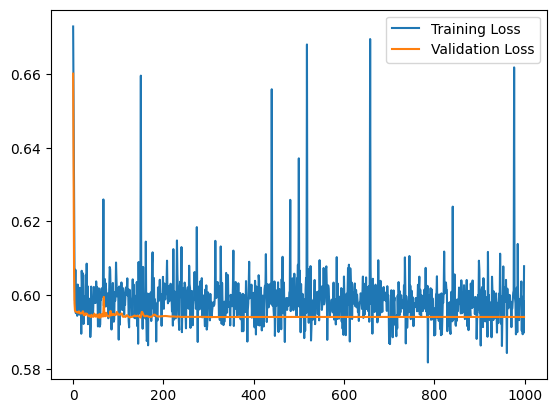

In [49]:
import matplotlib.pyplot as plt


plt.plot(range(len(epoch_train_losses)), epoch_train_losses, label='Training Loss')
plt.plot(range(len(epoch_val_losses)), epoch_val_losses, label='Validation Loss')
plt.legend()

# Decoder

In [6]:
%load_ext autoreload
%autoreload 2

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from layers.graph_transformer_edge_layer import EncoderDecoderLayer

class DecoderBlock(nn.Module):
    def __init__(self, in_dim, out_dim, num_heads, dropout=0.0, layer_norm=False, batch_norm=True, residual=True, use_bias=False):
        super().__init__()
        self.l1 = GraphTransformerLayer(in_dim, out_dim, num_heads, dropout,
                                                    layer_norm, batch_norm, residual,use_FFN=False)
        self.l2 = EncoderDecoderLayer(out_dim, out_dim, out_dim, num_heads, dropout,
                                                    layer_norm, batch_norm, residual)    
    def forward(self, g, h, e, h2, e2, mask):
        hidden_h, hidden_e = self.l1(g,h,e,mask)
        return self.l2(g,h2,e2,hidden_h, hidden_e)

class GraphTransformerNetDec(nn.Module):
    def __init__(self, net_params):
        super().__init__()
        self.fft = net_params['fft']
        num_states = net_params['num_states']
        num_trade_indicators = net_params['num_trade_indicators']
        self.hidden_dim = net_params['hidden_dim']
        num_heads = net_params['n_heads']
        self.num_heads = num_heads
        out_dim = net_params['out_dim']
        in_feat_dropout = net_params['in_feat_dropout']
        dropout = net_params['dropout']
        n_enc_layers = net_params['encL']
        n_dec_layers = net_params['decL']

        self.layer_norm = net_params['layer_norm']
        self.batch_norm = net_params['batch_norm']
        self.residual = net_params['residual']
        self.edge_feat = net_params['edge_feat']
        self.device = net_params['device']
        self.lap_pos_enc = net_params['lap_pos_enc']
        self.wl_pos_enc = net_params['wl_pos_enc']
        max_wl_role_index = net_params['max_cluster_size'] # this is maximum graph size in the dataset
        self.num_states = num_states
        if self.lap_pos_enc:
            pos_enc_dim = net_params['pos_enc_dim']
            self.embedding_lap_pos_enc = nn.Linear(pos_enc_dim, self.hidden_dim,dtype=torch.double)
        if self.wl_pos_enc:
            self.embedding_wl_pos_enc = nn.Embedding(max_wl_role_index, self.hidden_dim)
        
        #self.embedding_h = nn.Linear(1, self.hidden_dim,dtype=torch.double)
        self.embedding_h = nn.GRUCell(1, self.hidden_dim,dtype=torch.double)
        self.embedding_h_dec = nn.Linear(1, self.hidden_dim,dtype=torch.double)        

        if self.edge_feat:
            #self.embedding_e = nn.Embedding(num_trade_indicators, hidden_dim)
            self.embedding_e = nn.GRUCell(2, self.hidden_dim,dtype=torch.double)
            self.embedding_e_dec = nn.Linear(1, self.hidden_dim,dtype=torch.double)
        else:
            self.embedding_e = nn.Linear(2, self.hidden_dim,dtype=torch.double)
            self.embedding_e_dec = nn.Linear(1, self.hidden_dim,dtype=torch.double)
        
        self.in_feat_dropout = nn.Dropout(in_feat_dropout)
        self._loss = torch.nn.BCELoss()

        self.enc_layers = nn.ModuleList([GraphTransformerLayer(self.hidden_dim, self.hidden_dim, num_heads, dropout,
                                                    self.layer_norm, self.batch_norm, self.residual) for _ in range(n_enc_layers) ]) 
        self.dec_layers = nn.ModuleList([DecoderBlock(self.hidden_dim, self.hidden_dim, num_heads, dropout,
                                                    self.layer_norm, self.batch_norm, self.residual) for _ in range(n_dec_layers) ])
        self.MLP_layer = MLPReadout(self.hidden_dim, 1,1,self.fft)
        self.eps = 1e-12
        
    def forward(self, g1, h1, e1, g2, h2, e2, mask, h_lap_pos_enc=None, h_wl_pos_enc=None):
        # input embedding
        h1 = self.embedding_h(h1[:,self.hidden_dim:],h1[:,:self.hidden_dim])
        h2 = self.embedding_h_dec(h2)
        #h = self.in_feat_dropout(h)
        if self.lap_pos_enc:
            h_lap_pos_enc = self.embedding_lap_pos_enc(h_lap_pos_enc.double()) 
            h1 = h1 + h_lap_pos_enc
            h2 = h2 + h_lap_pos_enc
        if self.wl_pos_enc:
            h_wl_pos_enc = self.embedding_wl_pos_enc(h_wl_pos_enc) 
            h1 = h1 + h_wl_pos_enc
            h2 = h2 + h_wl_pos_enc

        #print("e2:",e2)
            
        if not self.fft:
            e1 = self.embedding_e(e1[:,self.hidden_dim:],e1[:,:self.hidden_dim])  
            e2 = self.embedding_e_dec(e2)              
        else:    
            e1 = self.embedding_e(torch.fft.fft(e1[:,self.hidden_dim:]),e1[:,:self.hidden_dim])  
            e2 = self.embedding_e_dec(torch.fft.fft(e2))  
        #print("h: ", h.shape)
        #print("e22: ", e2)
        
        #ENCODER
        # convnets
        for conv in self.enc_layers:
            h1, e1 = conv(g1, h1, e1)
        g1.ndata['h'] = h1
        g1.edata['h'] = e1
        
        #DECODER
        
        for i,conv in enumerate(self.dec_layers):
            #print("dec layer ", i)
            h2, e2 = conv(g2,h2,e2,h1,e1, mask)
        
        e2 = e2.reshape((-1,e2.shape[1]))

        g2.ndata['h'] = h2
        g2.edata['h'] = e2        

        #OUTPUT
        mlp = self.MLP_layer(e2)

        if self.fft:
            mlp = F.sigmoid(torch.fft.ifft(mlp))
        return mlp.reshape(1,-1), e1, h1, e2, h2
        
        
    def loss(self, scores, targets):
        loss = self._loss(scores,targets)
        #loss = nn.L1Loss()(scores, targets)
        return loss

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
def train_epoch(model, optimizer, device, data_loader, epoch):
    model.train()
    epoch_loss = 0
    epoch_train_mae = 0
    nb_data = 0
    gpu_mem = 0

    y_pred = []   
    y_true = []    
    losses = []
    for iter, (batch_graphs_, batch_targets_, batch_targets_n_) in enumerate(data_loader):
        batch_scores = None
        batch_vert_scores = None
        batch_dec_scores = None
        batch_dec_vert_scores = None        
        batch_res = []
        bt = []
        bx = []
        be = []
        loss_mask = []

        optimizer.zero_grad()        
        for t in range(len(batch_targets_)):
            batch_graphs = batch_graphs_[t]

            batch_targets = batch_targets_[t]
            batch_graphs = batch_graphs.to(device)
            batch_x_ = batch_graphs.ndata['feat'].reshape(-1,1).to(device)  # num x feat
            batch_e = batch_graphs.edata['feat'].reshape(-1,2).to(device)
            if t > 0:
                batch_e = torch.hstack([batch_scores, batch_e])
                batch_x = torch.hstack([batch_vert_scores, batch_x_])                
            else:
                batch_e = torch.hstack([torch.randn((batch_e.shape[0],model.hidden_dim)), batch_e])
                batch_x = torch.hstack([torch.randn((batch_x_.shape[0],model.hidden_dim)), batch_x_])                
                
            
            batch_targets_n = batch_targets_n_[t]
            batch_targets_n = batch_targets_n.to(device)
            batch_tx = batch_targets_n.ndata['feat'].reshape(-1,1).to(device)  # num x feat
            batch_te = batch_targets_n.edata['feat'].reshape(-1,1).to(device)  
            masked_edges = batch_targets_n.edata['mask'].flatten().to(device)  

            # if t > 0:
            #     batch_te = torch.hstack([batch_dec_scores, batch_te])
            #     batch_tx = torch.hstack([batch_dec_vert_scores, batch_tx])                
            # else:
            #     batch_te = torch.hstack([torch.randn((batch_te.shape[0],model.hidden_dim)), batch_te])
            #     batch_tx = torch.hstack([torch.randn((batch_tx.shape[0],model.hidden_dim)), batch_tx])                
            
            batch_targets = batch_targets.edata['feat'].reshape(1,-1)
            #ez = torch.zeros((1,model.num_states*model.num_states - batch_targets.shape[1]))
            #batch_targets = torch.hstack([batch_targets,ez])
            batch_targets = batch_targets.to(device)
            bt.append(batch_targets)
            bx = batch_x_[batch_graphs.edges("all")[0]]
            #be.append(torch.hstack([batch_e, bx]))
            be = torch.hstack([batch_e, bx])
            
            try:
                batch_lap_pos_enc = batch_graphs.ndata['lap_pos_enc'].to(device)
                sign_flip = torch.rand(batch_lap_pos_enc.size(1)).to(device)
                sign_flip[sign_flip>=0.5] = 1.0; sign_flip[sign_flip<0.5] = -1.0
                batch_lap_pos_enc = batch_lap_pos_enc * sign_flip.unsqueeze(0)
            except:
                batch_lap_pos_enc = None
                
            try:
                batch_wl_pos_enc = batch_graphs.ndata['wl_pos_enc'].to(device)
            except:
                batch_wl_pos_enc = None
    
            mask = torch.zeros((batch_e.shape[0],model.num_heads,1))
            loss_mask.append(masked_edges)

            batch_res_, batch_scores, batch_vert_scores, batch_dec_scores, batch_dec_vert_scores = model.forward(batch_graphs, batch_x, batch_e, batch_targets_n, batch_tx, batch_te, mask, batch_lap_pos_enc, batch_wl_pos_enc)
            batch_res.append(batch_res_)

        ten = torch.nan_to_num(torch.hstack(batch_res).flatten().real,nan=0., posinf=1 - model.eps,neginf=model.eps)
        loss_mask = torch.hstack(loss_mask)
        #print(loss_mask.sum())
        loss = model.loss(ten.masked_fill(~loss_mask,0.), torch.hstack(bt).flatten().masked_fill(~loss_mask,0.))
        #loss = model.loss(ten, torch.hstack(bt).flatten())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        loss = model.loss(ten[loss_mask], torch.hstack(bt).flatten()[loss_mask])
        epoch_loss += loss.detach().item()

        nb_data += batch_targets.size(0)
    epoch_loss /= (iter + 1)

    return epoch_loss, optimizer

def evaluate_network(model, device, data_loader, epoch):
    model.eval()
    epoch_test_loss = 0
    epoch_test_mae = 0
    nb_data = 0
    losses = []
    with torch.no_grad():
        for iter, (batch_graphs_, batch_targets_, batch_targets_n_) in enumerate(data_loader):
            batch_scores = None
            batch_vert_scores = None
            batch_dec_scores = None
            batch_dec_vert_scores = None               
            batch_res = []  
            bt = []
            loss_mask = []
            for t in range(len(batch_targets_)):
                batch_graphs = batch_graphs_[t]
                batch_targets = batch_targets_[t]            
                batch_graphs = batch_graphs.to(device)
                batch_x_ = batch_graphs.ndata['feat'].reshape(-1,1).to(device)
                batch_e = batch_graphs.edata['feat'].reshape(-1,2).to(device)
                
                if t > 0:
                    batch_e = torch.hstack([batch_scores, batch_e])
                    batch_x = torch.hstack([batch_vert_scores, batch_x_])                    
                else:
                    batch_e = torch.hstack([torch.zeros((batch_e.shape[0],model.hidden_dim)), batch_e])
                    batch_x = torch.hstack([torch.zeros((batch_x_.shape[0],model.hidden_dim)), batch_x_])
                
                batch_targets_n = batch_targets_n_[t]
                batch_targets_n = batch_targets_n.to(device)
                batch_tx = batch_targets_n.ndata['feat'].reshape(-1,1).to(device)  # num x feat
                batch_te = batch_targets_n.edata['feat'].reshape(-1,1).to(device)    
                masked_edges = batch_targets_n.edata['mask'].flatten().to(device) 
                 
                
                batch_targets = batch_targets.edata['feat'].reshape(1,-1)
                #ez = torch.zeros((1,model.num_states*model.num_states - batch_targets.shape[1]))
                #batch_targets = torch.hstack([batch_targets,ez])
                batch_targets = batch_targets.to(device)

                bt.append(batch_targets)
                try:
                    batch_lap_pos_enc = batch_graphs.ndata['lap_pos_enc'].to(device)
                except:
                    batch_lap_pos_enc = None
                
                try:
                    batch_wl_pos_enc = batch_graphs.ndata['wl_pos_enc'].to(device)
                except:
                    batch_wl_pos_enc = None

                bx = batch_x_[batch_graphs.edges("all")[0]]
                #be.append(torch.hstack([batch_e, bx]))
                be = torch.hstack([batch_e, bx])  
                
                mask = torch.zeros((batch_e.shape[0],model.num_heads,1))
                loss_mask.append(masked_edges)
               
                batch_res_, batch_scores, batch_vert_scores, batch_dec_scores, batch_dec_vert_scores = model.forward(batch_graphs, batch_x, batch_e, batch_targets_n, batch_tx, batch_te,mask,batch_lap_pos_enc, batch_wl_pos_enc)
                batch_res.append(batch_res_)

            ten = torch.nan_to_num(torch.hstack(batch_res).flatten().real,nan=0., posinf=1 - model.eps,neginf=model.eps)
            #print(ten[ten<0],ten[ten == 0],ten[ten>1],ten[ten==1],torch.isnan(ten).any(),torch.isinf(ten).any())
            loss_mask = torch.hstack(loss_mask)
            loss = model.loss(ten.masked_fill(~loss_mask,0.), torch.hstack(bt).flatten().masked_fill(~loss_mask,0.))
            #loss = model.loss(ten, torch.hstack(bt).flatten())
            loss = model.loss(ten[loss_mask], torch.hstack(bt).flatten()[loss_mask])            
            epoch_test_loss += loss.detach().item()
            nb_data += batch_targets.size(0)
        epoch_test_loss /= (iter + 1)
        
    return epoch_test_loss 

def test_network(model, device, data_loader):
    model.eval()
    epoch_test_loss = 0
    epoch_test_mae = 0
    nb_data = 0
    batch_res = []
    batch_tar = []
    labeled_pred = []
    loss_mask = []
    with torch.no_grad():
        for iter, (batch_graphs_, batch_targets_, batch_targets_n_) in enumerate(data_loader):
            batch_scores = None
            batch_vert_scores = None
            batch_dec_scores = None
            batch_dec_vert_scores = None               
            bt = []
            for t in range(len(batch_targets_)):
                batch_graphs = batch_graphs_[t]
                batch_targets = batch_targets_[t]            
                batch_graphs = batch_graphs.to(device)
                batch_x_ = batch_graphs.ndata['feat'].reshape(-1,1).to(device)
                batch_e = batch_graphs.edata['feat'].reshape(-1,2).to(device)
                
                if t > 0:
                    batch_e = torch.hstack([batch_scores, batch_e])
                    batch_x = torch.hstack([batch_vert_scores, batch_x_])
                else:
                    batch_e = torch.hstack([torch.zeros((batch_e.shape[0],model.hidden_dim)), batch_e])
                    batch_x = torch.hstack([torch.zeros((batch_x_.shape[0],model.hidden_dim)), batch_x_])

                batch_targets_n = batch_targets_n_[t]
                batch_targets_n = batch_targets_n.to(device)
                batch_tx = batch_targets_n.ndata['feat'].reshape(-1,1).to(device)  # num x feat
                batch_te = batch_targets_n.edata['feat'].reshape(-1,1).to(device)    
                masked_edges = batch_targets_n.edata['mask'].flatten().to(device)   
                # if t > 0:
                #     batch_te = torch.hstack([batch_dec_scores, batch_te])
                #     batch_tx = torch.hstack([batch_dec_vert_scores, batch_tx])                
                # else:
                #     batch_te = torch.hstack([torch.randn((batch_te.shape[0],model.hidden_dim)), batch_te])
                #     batch_tx = torch.hstack([torch.randn((batch_tx.shape[0],model.hidden_dim)), batch_tx])                    
                
                batch_targets = batch_targets.edata['feat'].reshape(1,-1)
                #ez = torch.zeros((1,model.num_states*model.num_states - batch_targets.shape[1]))
                #batch_targets = torch.hstack([batch_targets,ez])
                batch_targets = batch_targets.to(device)

                bt.append(batch_targets)
                try:
                    batch_lap_pos_enc = batch_graphs.ndata['lap_pos_enc'].to(device)
                except:
                    batch_lap_pos_enc = None
                
                try:
                    batch_wl_pos_enc = batch_graphs.ndata['wl_pos_enc'].to(device)
                except:
                    batch_wl_pos_enc = None

                bx = batch_x_[batch_graphs.edges("all")[0]]
                #be.append(torch.hstack([batch_e, bx]))
                be = torch.hstack([batch_e, bx])                

                mask = torch.zeros((batch_e.shape[0],model.num_heads,1))
                loss_mask.append(masked_edges)

                invals =  batch_graphs.edges("all")[0]
                outvals = batch_graphs.edges("all")[1]
                batch_res_, batch_scores, batch_vert_scores, batch_dec_scores, batch_dec_vert_scores = model.forward(batch_graphs, batch_x, batch_e, batch_targets_n, batch_tx, batch_te,mask,batch_lap_pos_enc, batch_wl_pos_enc)
                #labeled_pred [t,[(i,j,value),..,]]
                
                labeled_pred.append([t,[(i,j,batch_res_[0,k]) for k,(i,j) in enumerate(zip(invals,outvals))]])
                batch_res.append(batch_res_.flatten())
                batch_tar.append(batch_targets.flatten())    
                
    loss_mask = torch.hstack(loss_mask)
    if loss_mask.sum() > 0:
        ynn_test = torch.hstack(batch_tar).detach()[loss_mask].cpu().numpy()
        y_pred = torch.hstack(batch_res).detach()[loss_mask].cpu().real.numpy()
    else:
        ynn_test = torch.hstack(batch_tar).detach().cpu().numpy()
        y_pred = torch.hstack(batch_res).detach().cpu().real.numpy()

    print(ynn_test[:30], y_pred[:30])
    mse_score = mean_squared_error(ynn_test.flatten() * features_max[0],y_pred.flatten() * features_max[0])
    mae_score = mean_absolute_error(ynn_test.flatten() * features_max[0],y_pred.flatten() * features_max[0])
    r2_ = r2_score(ynn_test.flatten(),y_pred.flatten())
    return mse_score,mae_score,r2_,ynn_test.flatten() - y_pred.flatten(),labeled_pred 

In [8]:
from scipy.stats import laplace

class TradeDGLDecoder(TradeDGL):
    def __init__(self, data,device, random_ratio = 0.8):
        self.data = data
        self.device = device
        self.num_graphs = len(data)
                
        """
        data is a list of TradeUnion dict objects with following attributes
        
          un = data[idx]
        ; un['num_states'] : nb of states, an integer (N)
        ; un['production'] : tensor of size N, each element is a production value, a float number > 0
        ; un['export'] : tensor of size N x N, each element is a value of export, a float number > 0
        ; un['pred_export'] : tensor of size N x N, each element is a value of export, a float number > 0
        """
        
        self.graph_lists = []
        self.graph_labels = []
        self.graph_noisy_labels = []
        self.n_samples = len(self.data)
        self.random_ratio = random_ratio        
        self._prepare()

    # form a mini batch from a given list of samples = [(graph, label) pairs]
    def collate(self, samples):
        # The input samples is a list of pairs (graph, label).
        graphs, labels, noised_labels = map(list, zip(*samples))
        batched_graphs = []
        labels_ = []
        noised_labels_ = []
        for i in range(len(graphs[0])):
            blabels = dgl.batch([l[i] for l in labels]) 
            bnlabels = dgl.batch([l[i] for l in noised_labels]) 
            batched_graph = dgl.batch([g[i] for g in graphs])       
            batched_graphs.append(batched_graph)          
            labels_.append(blabels)
            noised_labels_.append(bnlabels)
        return batched_graphs, labels_, noised_labels_
    
    def _prepare(self):
        all_countries = []
        for c,y in self.data:
            all_countries += list(self.data[(c,y)][0].keys())

        self.all_countries = list(set(all_countries))
        self.le = LabelEncoder().fit(all_countries)
        tars = [] 
        prods = []
        for c,y in self.data:
            for t in range(5):
                tar = np.zeros((len(all_countries),len(all_countries)))
                prod = np.zeros((len(all_countries),))
                for j,k in self.data[(c,y)][1]:
                    j_ = self.le.transform([j])[0]
                    k_ = self.le.transform([k])[0]  
                    tar[j_,k_] = self.data[(c,y)][1][j,k][1][t]          
                    prod[j_] = self.data[(c,y)][1][j,k][0][t,2]
                    prod[k_] = self.data[(c,y)][1][j,k][0][t,3]
                
                tars.append(tar)
                prods.append(prod)

        tars = np.hstack(tars).flatten()
        prods = np.hstack(prods).flatten()

        #self.tar_loc, self.tar_scale = laplace.fit(tars)
        #self.prod_loc, self.prod_scale = laplace.fit(prods)

        #random_tars = laplace.rvs(self.tar_loc,self.tar_scale,size=len(tars))
        #random_prods = laplace.rvs(self.prod_loc, self.prod_scale,size=len(prods))

        for c,y in self.data:
            dat_label = []
            dat_cluster = []
            dat_random_label = []
            for t in range(5):
                prod = np.zeros((len(all_countries),))
                expt = np.zeros((len(all_countries),len(all_countries),2))
                tar = np.zeros((len(all_countries),len(all_countries)))
                random_tar = np.zeros((len(all_countries),len(all_countries)))
                random_prod = np.zeros((len(all_countries),))
                random_mask = np.zeros((len(all_countries),len(all_countries)),dtype=bool)

                inidxs = []
                outidxs = []
                for j,k in self.data[(c,y)][1]:
                    j_ = self.le.transform([j])[0]
                    k_ = self.le.transform([k])[0]                    
                    inidxs.append(j_)
                    outidxs.append(k_)
                    expt[j_,k_] = self.data[(c,y)][1][j,k][0][t,:2]
                    prod[j_] = self.data[(c,y)][1][j,k][0][t,2]
                    prod[k_] = self.data[(c,y)][1][j,k][0][t,3]
                    tar[j_,k_] = self.data[(c,y)][1][j,k][1][t]    
                    if len(self.data[(c,y)]) > 2:
                        #use pre-defined values:
                        preprod_j = self.data[(c,y)][2][j,k][0][t,2]
                        preprod_k = self.data[(c,y)][2][j,k][0][t,3]
                        pretar = self.data[(c,y)][2][j,k][1][t]                           
                        random_tar[j_,k_] = pretar
                        random_prod[j_] = preprod_j
                        random_prod[k_] = preprod_k
                    else:    
                        if bool(np.random.choice([0,1], 1, p=[self.random_ratio, 1. - self.random_ratio])[0]):
                            random_tar[j_,k_] = tar[j_,k_]
                            random_prod[j_] = prod[j_] 
                            random_prod[k_] = prod[k_]
                        else:    
                            random_tar[j_,k_] = self.data[(c,y)][1][j,k][0][t,:1]
                            random_mask[j_,k_] = True
                            random_prod[j_] = prod[j_]
                            random_prod[k_] = prod[k_]
                        
                node_features = torch.from_numpy(prod).to(device=self.device)

                adj = torch.from_numpy(expt).to(device=self.device)
    
                edge_features = adj[inidxs,outidxs].reshape(-1,2)
                
                # Create the DGL Graph
                g = dgl.DGLGraph()
                g.my_id = (y,c,t)
                g.add_nodes(len(all_countries))
                g.ndata['feat'] = node_features
                
                for src, dst in zip(inidxs,outidxs):
                    g.add_edges(src.item(), dst.item())
                g.edata['feat'] = edge_features
                dat_cluster.append(g)
                
                # Create the target DGL Graph
                g = dgl.DGLGraph()
                g.my_id = (y,c,t,"tar")
                g.add_nodes(len(all_countries))
                #g.ndata['feat'] = torch.zeros(prod.shape).to(device=self.device)
                adj = torch.from_numpy(tar).to(device=self.device)

                edge_features = adj[inidxs,outidxs].reshape(-1)
                
                for src, dst in zip(inidxs,outidxs):
                    g.add_edges(src.item(), dst.item())
      
                                
                g.edata['feat'] = edge_features   
                dat_label.append(g)

                #generate randomized output graph
                g = dgl.DGLGraph()
                g.my_id = (y,c,t,"random_tar")
                g.add_nodes(len(all_countries))
                node_features = torch.from_numpy(random_prod).to(device=self.device)
                g.ndata['feat'] = node_features
                adj = torch.from_numpy(random_tar).to(device=self.device)

                edge_features = adj[inidxs,outidxs].reshape(-1)
                
                for src, dst in zip(inidxs,outidxs):
                    g.add_edges(src.item(), dst.item())
      
                random_mask = torch.from_numpy(random_mask).to(device=self.device)[inidxs,outidxs].reshape(-1)
                g.edata['feat'] = edge_features   
                g.edata['mask'] = random_mask
                dat_random_label.append(g)
            
            self.graph_labels.append(dat_label)
            self.graph_lists.append(dat_cluster)            
            self.graph_noisy_labels.append(dat_random_label)            

    def __getitem__(self, idx):
        """
            Get the idx^th sample.
            Parameters
            ---------
            idx : int
                The sample index.
            Returns
            -------
            (dgl.DGLGraph, int)
                DGLGraph with node feature stored in `feat` field
                And its label.
        """
        return self.graph_lists[idx], self.graph_labels[idx], self.graph_noisy_labels[idx]

In [9]:
import time
from torch import optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import warnings
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

max_cluster_size = 0

lap_pos_enc = True
wl_pos_enc = True
device = "cpu"
batch_size = 8
epochs = 3000

root_log_dir = ""
root_ckpt_dir = "checkpoints"
write_file_name = ""
write_config_file = ""
min_lr = 0.00000001

cy_train, cy_test = train_test_split(list(cluster_year.keys()),train_size=0.8)

train_dataset = TradeDGLDecoder({k:cluster_year[k] for k in cy_train},device,random_ratio = 0.5)
test_dataset = TradeDGLDecoder({k:cluster_year[k] for k in cy_test},device,random_ratio = 1.0)
net_params = {}

net_params['fft'] = False
net_params['num_trade_indicators'] = 1
net_params['hidden_dim'] = 4
net_params['n_heads'] = 2
net_params['out_dim'] = 1
net_params['in_feat_dropout'] = 0.
net_params['dropout'] = 0.0
net_params['encL'] = 1
net_params['decL'] = 1
net_params['layer_norm'] = False
net_params['batch_norm'] = False
net_params['residual'] = True
net_params['edge_feat'] = True
net_params['device'] = device
net_params['lap_pos_enc'] = lap_pos_enc
net_params['wl_pos_enc'] = wl_pos_enc
net_params['max_cluster_size'] = max(len(train_dataset.all_countries),len(test_dataset.all_countries))
net_params['pos_enc_dim'] = 4


net_params['num_states'] = max(len(train_dataset.all_countries),len(test_dataset.all_countries))

if lap_pos_enc:
    st = time.time()

    
    print("[!] Adding Laplacian positional encoding.")
    train_dataset._add_laplacian_positional_encodings(net_params['pos_enc_dim'])
    test_dataset._add_laplacian_positional_encodings(net_params['pos_enc_dim'])
    print('Time LapPE:',time.time()-st)
    
if wl_pos_enc:
    st = time.time()
    print("[!] Adding WL positional encoding.")
    train_dataset._add_wl_positional_encodings()
    test_dataset._add_wl_positional_encodings()
    print('Time WL PE:',time.time()-st)

trainset, valset = torch.utils.data.random_split(train_dataset, [0.8,0.2])


model = GraphTransformerNetDec(net_params)
#model = SimpleGRU(net_params['hidden_dim'])
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                 factor=0.5,
                                                 patience=50,
                                                 verbose=True)

epoch_train_losses, epoch_val_losses = [], []
    

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, collate_fn=train_dataset.collate)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=test_dataset.collate)
min_loss = 100000
min_val = 0
min_name = ""    
try:
    with tqdm(range(epochs)) as t:
        for epoch in t:

            t.set_description('Epoch %d' % epoch)

            start = time.time()

            epoch_train_loss, optimizer = train_epoch(model, optimizer, device, train_loader, epoch)
                
            epoch_val_loss = evaluate_network(model, device, val_loader, epoch)

            # Saving checkpoint
            ckpt_dir = os.path.join(root_ckpt_dir, "RUN_")
            if not os.path.exists(ckpt_dir):
                os.makedirs(ckpt_dir)
                
            if epoch_train_loss < min_loss:
                min_loss = epoch_train_loss
                print(min_loss,epoch_val_loss)
                min_val = epoch_val_loss
                min_name = '{}.pkl'.format(ckpt_dir + "/epoch_" + str(epoch))
                
            epoch_train_losses.append(epoch_train_loss)
            epoch_val_losses.append(epoch_val_loss)
            t.set_postfix(time=time.time()-start, lr=optimizer.param_groups[0]['lr'],
                          train_loss=epoch_train_loss, val_loss=epoch_val_loss)
            

            torch.save(model.state_dict(), '{}.pkl'.format(ckpt_dir + "/epoch_" + str(epoch)))


            scheduler.step(epoch_val_loss)

except KeyboardInterrupt:
    print('-' * 89)
    print('Exiting from training early because of KeyboardInterrupt')

print("Convergence Time (Epochs): {:.4f}".format(epoch))

print("Min loss:", min_loss,min_val)

model = GraphTransformerNetDec(net_params)
model.load_state_dict(torch.load(min_name, weights_only=True))

#writer.close()

[!] Adding Laplacian positional encoding.
Time LapPE: 5.278119087219238
[!] Adding WL positional encoding.
Time WL PE: 1.0828883647918701


Epoch 1:   0%| | 1/3000 [00:08<7:05:44,  8.52s/it, lr=0.01, time=8.51, train_los

0.5815591007623894 0.5326838215561298


Epoch 2:   0%| | 2/3000 [00:16<7:02:29,  8.46s/it, lr=0.01, time=8.41, train_los

0.45648708532822724 0.39255612040856935


Epoch 3:   0%| | 3/3000 [00:25<6:59:50,  8.41s/it, lr=0.01, time=8.34, train_los

0.30140916913708604 0.32475004045830047


Epoch 4:   0%| | 4/3000 [00:33<7:01:16,  8.44s/it, lr=0.01, time=8.48, train_los

0.2455968832877451 0.3595992116503769


Epoch 5:   0%| | 5/3000 [00:42<7:01:01,  8.43s/it, lr=0.01, time=8.43, train_los

0.2402316470375503 0.3408719465500792


Epoch 6:   0%| | 6/3000 [00:50<7:00:14,  8.42s/it, lr=0.01, time=8.39, train_los

0.23901484517368127 0.3112976818162791


Epoch 7:   0%| | 7/3000 [00:59<7:00:53,  8.44s/it, lr=0.01, time=8.46, train_los

0.2249791090994318 0.3100181229209533


Epoch 10:   0%| | 10/3000 [01:24<7:03:47,  8.50s/it, lr=0.01, time=8.67, train_l

0.21665497738233858 0.32200296064819134


Epoch 12:   0%| | 12/3000 [01:42<7:16:05,  8.76s/it, lr=0.01, time=8.55, train_l

0.21117630580963742 0.3076630639829691


Epoch 13:   0%| | 13/3000 [01:51<7:09:44,  8.63s/it, lr=0.01, time=8.34, train_l

0.2102383190152981 0.3113443288342713


Epoch 15:   0%| | 15/3000 [02:08<7:12:47,  8.70s/it, lr=0.01, time=8.92, train_l

0.20931480606297392 0.30236897102981697


Epoch 16:   1%| | 16/3000 [02:17<7:13:06,  8.71s/it, lr=0.01, time=8.73, train_l

0.19580726054673595 0.30132635993276013


Epoch 17:   1%| | 17/3000 [02:25<7:07:49,  8.61s/it, lr=0.01, time=8.36, train_l

0.18997355534734126 0.2860376617456029


Epoch 18:   1%| | 18/3000 [02:34<7:04:47,  8.55s/it, lr=0.01, time=8.4, train_lo

0.17585485945711604 0.24851988504131273


Epoch 19:   1%| | 19/3000 [02:42<7:08:03,  8.62s/it, lr=0.01, time=8.77, train_l

0.15792023283860077 0.25117016507129425


Epoch 20:   1%| | 20/3000 [02:51<7:05:18,  8.56s/it, lr=0.01, time=8.43, train_l

0.15508874061170905 0.24720364792097696


Epoch 24:   1%| | 24/3000 [03:25<7:00:06,  8.47s/it, lr=0.01, time=8.37, train_l

0.1453793554598259 0.24472327743819366


Epoch 29:   1%| | 29/3000 [04:07<6:59:58,  8.48s/it, lr=0.01, time=8.4, train_lo

0.14407283820798897 0.2475189899445308


Epoch 38:   1%| | 38/3000 [05:23<6:56:23,  8.43s/it, lr=0.01, time=8.45, train_l

0.14242737990721951 0.24255621396771046


Epoch 52:   2%| | 52/3000 [07:21<6:57:14,  8.49s/it, lr=0.01, time=8.55, train_l

0.13953814661325298 0.24178712701419575


Epoch 57:   2%| | 57/3000 [08:04<7:01:16,  8.59s/it, lr=0.01, time=8.37, train_l

0.13773131628651153 0.24171007702003103


Epoch 61:   2%| | 61/3000 [08:38<6:55:18,  8.48s/it, lr=0.01, time=8.39, train_l

0.13600273213782965 0.24610752164993438


Epoch 98:   3%| | 98/3000 [13:51<6:47:03,  8.42s/it, lr=0.01, time=8.36, train_l

0.1304646137431324 0.24122150557735872


Epoch 526:  18%|▏| 526/3000 [1:11:57<5:33:57,  8.10s/it, lr=3.91e-5, time=8.09, 

0.1298767787986324 0.24146668469676846


Epoch 1039:  35%|▎| 1039/3000 [2:21:31<4:24:57,  8.11s/it, lr=3.81e-8, time=8.07

0.12755724235993265 0.24149728175280044


Epoch 2999: 100%|█| 3000/3000 [6:47:09<00:00,  8.14s/it, lr=1.91e-8, time=8.3, t

Convergence Time (Epochs): 2999.0000
Min loss: 0.12755724235993265 0.24149728175280044


<All keys matched successfully>

In [10]:
sq,a,r,residuals,_ = test_network(model, device, test_loader)
printf('Transformer: encoder-decoder',sq,a,r)

[6.67143422e-03 2.32827331e-02 2.76407730e-01 1.63385886e-02
 2.19863103e-01 1.13026799e-01 7.80935515e-03 3.59803578e-03
 4.31692693e-02 1.46970502e-02 1.23295891e-02 6.61448770e-04
 4.65270111e-02 8.93450713e-02 1.60435914e-02 3.76402024e-04
 2.85426598e-04 3.53031983e-04 1.58078292e-02 2.32046415e-02
 4.86398262e-02 7.76321327e-02 2.91139900e-03 5.03105253e-02
 1.84605005e-02 3.54295211e-01 1.25459034e-01 4.67457258e-02
 1.17590546e-01 1.64828041e-02] [0.01748795 0.06323804 0.00997239 0.00718756 0.16782949 0.05457494
 0.00213992 0.00284901 0.03818799 0.00343212 0.00511989 0.00198032
 0.05160219 0.03539711 0.0454592  0.00158577 0.00161337 0.00163251
 0.00435363 0.03110227 0.00722455 0.06322904 0.0020618  0.01129585
 0.02538064 0.2565765  0.00175113 0.04249722 0.10644878 0.00417612]
('Transformer: encoder-decoder', 9.714085832707962e+16, 142403652.58810768, 0.8695477575437767)


# DEMO

In [18]:
labeled_output = [[],[]]
demo_dataset = TradeDGLDecoder({(1,2018):cluster_year[1,2018]},device,random_ratio = 1.0)

if lap_pos_enc:
    st = time.time()
    print("[!] Adding Laplacian positional encoding.")
    demo_dataset._add_laplacian_positional_encodings(net_params['pos_enc_dim'])
    print('Time LapPE:',time.time()-st)
    
if wl_pos_enc:
    st = time.time()
    print("[!] Adding WL positional encoding.")
    demo_dataset._add_wl_positional_encodings()
    print('Time WL PE:',time.time()-st)

demo_loader = DataLoader(demo_dataset, batch_size=batch_size, shuffle=False, collate_fn=test_dataset.collate)
_,_,_,_,labeled_output[0] = test_network(model, device, demo_loader)

[!] Adding Laplacian positional encoding.
Time LapPE: 0.006382465362548828
[!] Adding WL positional encoding.
Time WL PE: 0.0020623207092285156
[1.43663951e-02 3.64799560e-02 2.24431325e-02 7.89176761e-05
 1.14515425e-01 6.59796813e-02 7.63733686e-02 2.61114381e-02
 1.92628064e-03 5.60770029e-02 3.20794105e-02 1.41606901e-02
 2.40549920e-03 6.33877705e-02 1.16472575e-01 8.89594595e-02
 1.10914695e-02 2.87131147e-01 2.29285579e-02 1.89726497e-04
 1.30943746e-01 5.86858040e-02 6.25299339e-02 3.34578265e-02
 3.03473962e-03 5.09507183e-02 3.54003520e-02 1.52543735e-02
 1.79192697e-03 4.77999641e-02] [0.01760561 0.10823189 0.03447098 0.00201949 0.28729422 0.0656717
 0.10729576 0.05360644 0.00343266 0.08165459 0.03999632 0.01909883
 0.00277684 0.06059369 0.15692255 0.07441264 0.02198914 0.08142991
 0.03682984 0.00260807 0.14131252 0.08186162 0.09228311 0.04027882
 0.00345854 0.07302204 0.04650667 0.02138611 0.00372109 0.07943537]


In [19]:
result_output_table = []

# add mask to simulate Australia/China cessation of trade

In [ ]:
import copy
cluster_year_mod = copy.deepcopy(cluster_year[1,2018])


cluster_year_mod.append({})
for j,k in cluster_year_mod[1]:
    if (j,k) not in cluster_year_mod[2]:
        cluster_year_mod[2][j,k] = cluster_year_mod[1][j,k]

#
j = le.transform([['Australia']])[0][0]
k = le.transform([['China']])[0][0]

jtar = le.transform([['Australia']])[0][0]
ktar = le.transform([['China']])[0][0]

for t in range(1,5):
    cluster_year_mod[2][j,k][0][t,0] = cluster_year_mod[1][j,k][0][t,0]
    cluster_year_mod[2][j,k][0][t,1] = cluster_year_mod[1][j,k][0][t,1]    
    cluster_year_mod[2][j,k][0][t,2] = cluster_year_mod[1][j,k][0][t,2]
    cluster_year_mod[2][j,k][0][t,3] = cluster_year_mod[1][j,k][0][t,3]
    cluster_year_mod[2][j,k][1][t] = 0.

demo_dataset = TradeDGLDecoder({(1,2018):cluster_year_mod},device,random_ratio = 1.0)



In [ ]:
if lap_pos_enc:
    st = time.time()
    print("[!] Adding Laplacian positional encoding.")
    demo_dataset._add_laplacian_positional_encodings(net_params['pos_enc_dim'])
    print('Time LapPE:',time.time()-st)
    
if wl_pos_enc:
    st = time.time()
    print("[!] Adding WL positional encoding.")
    demo_dataset._add_wl_positional_encodings()
    print('Time WL PE:',time.time()-st)

demo_loader = DataLoader(demo_dataset, batch_size=batch_size, shuffle=False, collate_fn=test_dataset.collate)
_,_,_,_,labeled_output[1] = test_network(model, device, demo_loader)

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

fig, axs = plt.subplots(5,2,figsize=(15, 35))


for n in range(2):
    k = 0
    for t, vals in labeled_output[n]:
        axs[t,n].set_title(t + 2018)
        G = nx.Graph()
        
        for i,j,v in vals:
            i_ = demo_dataset.le.inverse_transform([[int(i)]])[0]
            j_ = demo_dataset.le.inverse_transform([[int(j)]])[0]
            G.add_edge(le.inverse_transform([[i_]])[0][0], le.inverse_transform([[j_]])[0][0], weight= float(v))
            if n == 0:
                result_output_table.append([t + 2018,le.inverse_transform([[i_]])[0][0], le.inverse_transform([[j_]])[0][0], float(v)* features_max[0]])                        
            else:
                result_output_table[k] += [float(v)* features_max[0]]  
            k += 1    
        
        elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0.2]
        ealarge = [(u, v) for (u, v, d) in G.edges(data=True) if ((d["weight"] > 0.15) and (d["weight"] <= 0.2))]
        emed = [(u, v) for (u, v, d) in G.edges(data=True) if ((d["weight"] > 0.05) and (d["weight"] <= 0.15))]
        esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.05]
    
    
        if len(elarge + esmall+emed+ealarge) > 0:
            layout = nx.spring_layout(G, seed=7,weight=None)
            #nx.draw(G, layout)
            nx.draw_networkx_nodes(G, layout, node_size=200,alpha=0.4,ax=axs[t,n])
        
            # edges
            nx.draw_networkx_edges(G, layout, edgelist=elarge, width=1.5,alpha=0.5,edge_color="r",ax=axs[t,n])
            nx.draw_networkx_edges(
                G, layout, edgelist=ealarge, width=1.0, alpha=0.7, edge_color="y",ax=axs[t,n]
            )           
            nx.draw_networkx_edges(
                G, layout, edgelist=emed, width=0.9, alpha=0.7, edge_color="g",ax=axs[t,n]
            )        
            nx.draw_networkx_edges(
                G, layout, edgelist=esmall, width=0.5, alpha=0.7, edge_color="b",ax=axs[t,n]
            )
            
            # node labels
            nx.draw_networkx_labels(G, layout, font_size=12, font_family="sans-serif",ax=axs[t,n])
            # edge weight labels
            #edge_labels = nx.get_edge_attributes(G, "weight")
            #nx.draw_networkx_edge_labels(G, layout, edge_labels,font_size=6)
plt.tight_layout()
plt.savefig("constrained_model.png")        
plt.show()       

In [ ]:
pd.set_option('display.max_rows', 500)

pd.DataFrame(result_output_table,columns=["Year","Exporter","Importer","Unconstrained","Constrained: Au->China"]).to_csv("trade_model.csv",sep=";")

# add mask to simulate Australia/Indonesia cessation of trade

In [20]:
demo_dataset = TradeDGLDecoder({(1,2018):cluster_year[1,2018]},device,random_ratio = 1.0)

if lap_pos_enc:
    st = time.time()
    print("[!] Adding Laplacian positional encoding.")
    demo_dataset._add_laplacian_positional_encodings(net_params['pos_enc_dim'])
    print('Time LapPE:',time.time()-st)
    
if wl_pos_enc:
    st = time.time()
    print("[!] Adding WL positional encoding.")
    demo_dataset._add_wl_positional_encodings()
    print('Time WL PE:',time.time()-st)

demo_loader = DataLoader(demo_dataset, batch_size=batch_size, shuffle=False, collate_fn=test_dataset.collate)
_,_,_,_,labeled_output[0] = test_network(model, device, demo_loader)

[!] Adding Laplacian positional encoding.
Time LapPE: 0.0073969364166259766
[!] Adding WL positional encoding.
Time WL PE: 0.002121448516845703
[1.43663951e-02 3.64799560e-02 2.24431325e-02 7.89176761e-05
 1.14515425e-01 6.59796813e-02 7.63733686e-02 2.61114381e-02
 1.92628064e-03 5.60770029e-02 3.20794105e-02 1.41606901e-02
 2.40549920e-03 6.33877705e-02 1.16472575e-01 8.89594595e-02
 1.10914695e-02 2.87131147e-01 2.29285579e-02 1.89726497e-04
 1.30943746e-01 5.86858040e-02 6.25299339e-02 3.34578265e-02
 3.03473962e-03 5.09507183e-02 3.54003520e-02 1.52543735e-02
 1.79192697e-03 4.77999641e-02] [0.01760561 0.10823189 0.03447098 0.00201949 0.28729422 0.0656717
 0.10729576 0.05360644 0.00343266 0.08165459 0.03999632 0.01909883
 0.00277684 0.06059369 0.15692255 0.07441264 0.02198914 0.08142991
 0.03682984 0.00260807 0.14131252 0.08186162 0.09228311 0.04027882
 0.00345854 0.07302204 0.04650667 0.02138611 0.00372109 0.07943537]


In [21]:
import copy
cluster_year_mod = copy.deepcopy(cluster_year[1,2018])


cluster_year_mod.append({})
for j,k in cluster_year_mod[1]:
    if (j,k) not in cluster_year_mod[2]:
        cluster_year_mod[2][j,k] = cluster_year_mod[1][j,k]

#
j = le.transform([['Australia']])[0][0]
k = le.transform([['Viet Nam']])[0][0]

jtar = le.transform([['Australia']])[0][0]
ktar = le.transform([['Viet Nam']])[0][0]

for t in range(1,5):
    cluster_year_mod[2][j,k][0][t,0] = cluster_year_mod[1][j,k][0][t,0]
    cluster_year_mod[2][j,k][0][t,1] = cluster_year_mod[1][j,k][0][t,1]    
    cluster_year_mod[2][j,k][0][t,2] = cluster_year_mod[1][j,k][0][t,2]
    cluster_year_mod[2][j,k][0][t,3] = cluster_year_mod[1][j,k][0][t,3]
    cluster_year_mod[2][j,k][1][t] = 0.

demo_dataset = TradeDGLDecoder({(1,2018):cluster_year_mod},device,random_ratio = 1.0)



In [22]:
if lap_pos_enc:
    st = time.time()
    print("[!] Adding Laplacian positional encoding.")
    demo_dataset._add_laplacian_positional_encodings(net_params['pos_enc_dim'])
    print('Time LapPE:',time.time()-st)
    
if wl_pos_enc:
    st = time.time()
    print("[!] Adding WL positional encoding.")
    demo_dataset._add_wl_positional_encodings()
    print('Time WL PE:',time.time()-st)

demo_loader = DataLoader(demo_dataset, batch_size=batch_size, shuffle=False, collate_fn=test_dataset.collate)
_,_,_,_,labeled_output[1] = test_network(model, device, demo_loader)

[!] Adding Laplacian positional encoding.
Time LapPE: 0.010565519332885742
[!] Adding WL positional encoding.
Time WL PE: 0.002160310745239258
[1.43663951e-02 3.64799560e-02 2.24431325e-02 7.89176761e-05
 1.14515425e-01 6.59796813e-02 7.63733686e-02 2.61114381e-02
 1.92628064e-03 5.60770029e-02 3.20794105e-02 1.41606901e-02
 2.40549920e-03 6.33877705e-02 1.16472575e-01 8.89594595e-02
 1.10914695e-02 2.87131147e-01 2.29285579e-02 1.89726497e-04
 1.30943746e-01 5.86858040e-02 6.25299339e-02 3.34578265e-02
 3.03473962e-03 5.09507183e-02 3.54003520e-02 1.52543735e-02
 1.79192697e-03 4.77999641e-02] [0.0173781  0.07459472 0.03255248 0.00202808 0.13072857 0.07515127
 0.08484242 0.03562673 0.00269096 0.06694476 0.04118371 0.01689867
 0.0028957  0.07289835 0.13357539 0.09811505 0.01393944 0.32771917
 0.03726724 0.00265262 0.16759474 0.07520032 0.07864656 0.04809717
 0.00409621 0.06875789 0.05037083 0.02478849 0.0033883  0.06618161]


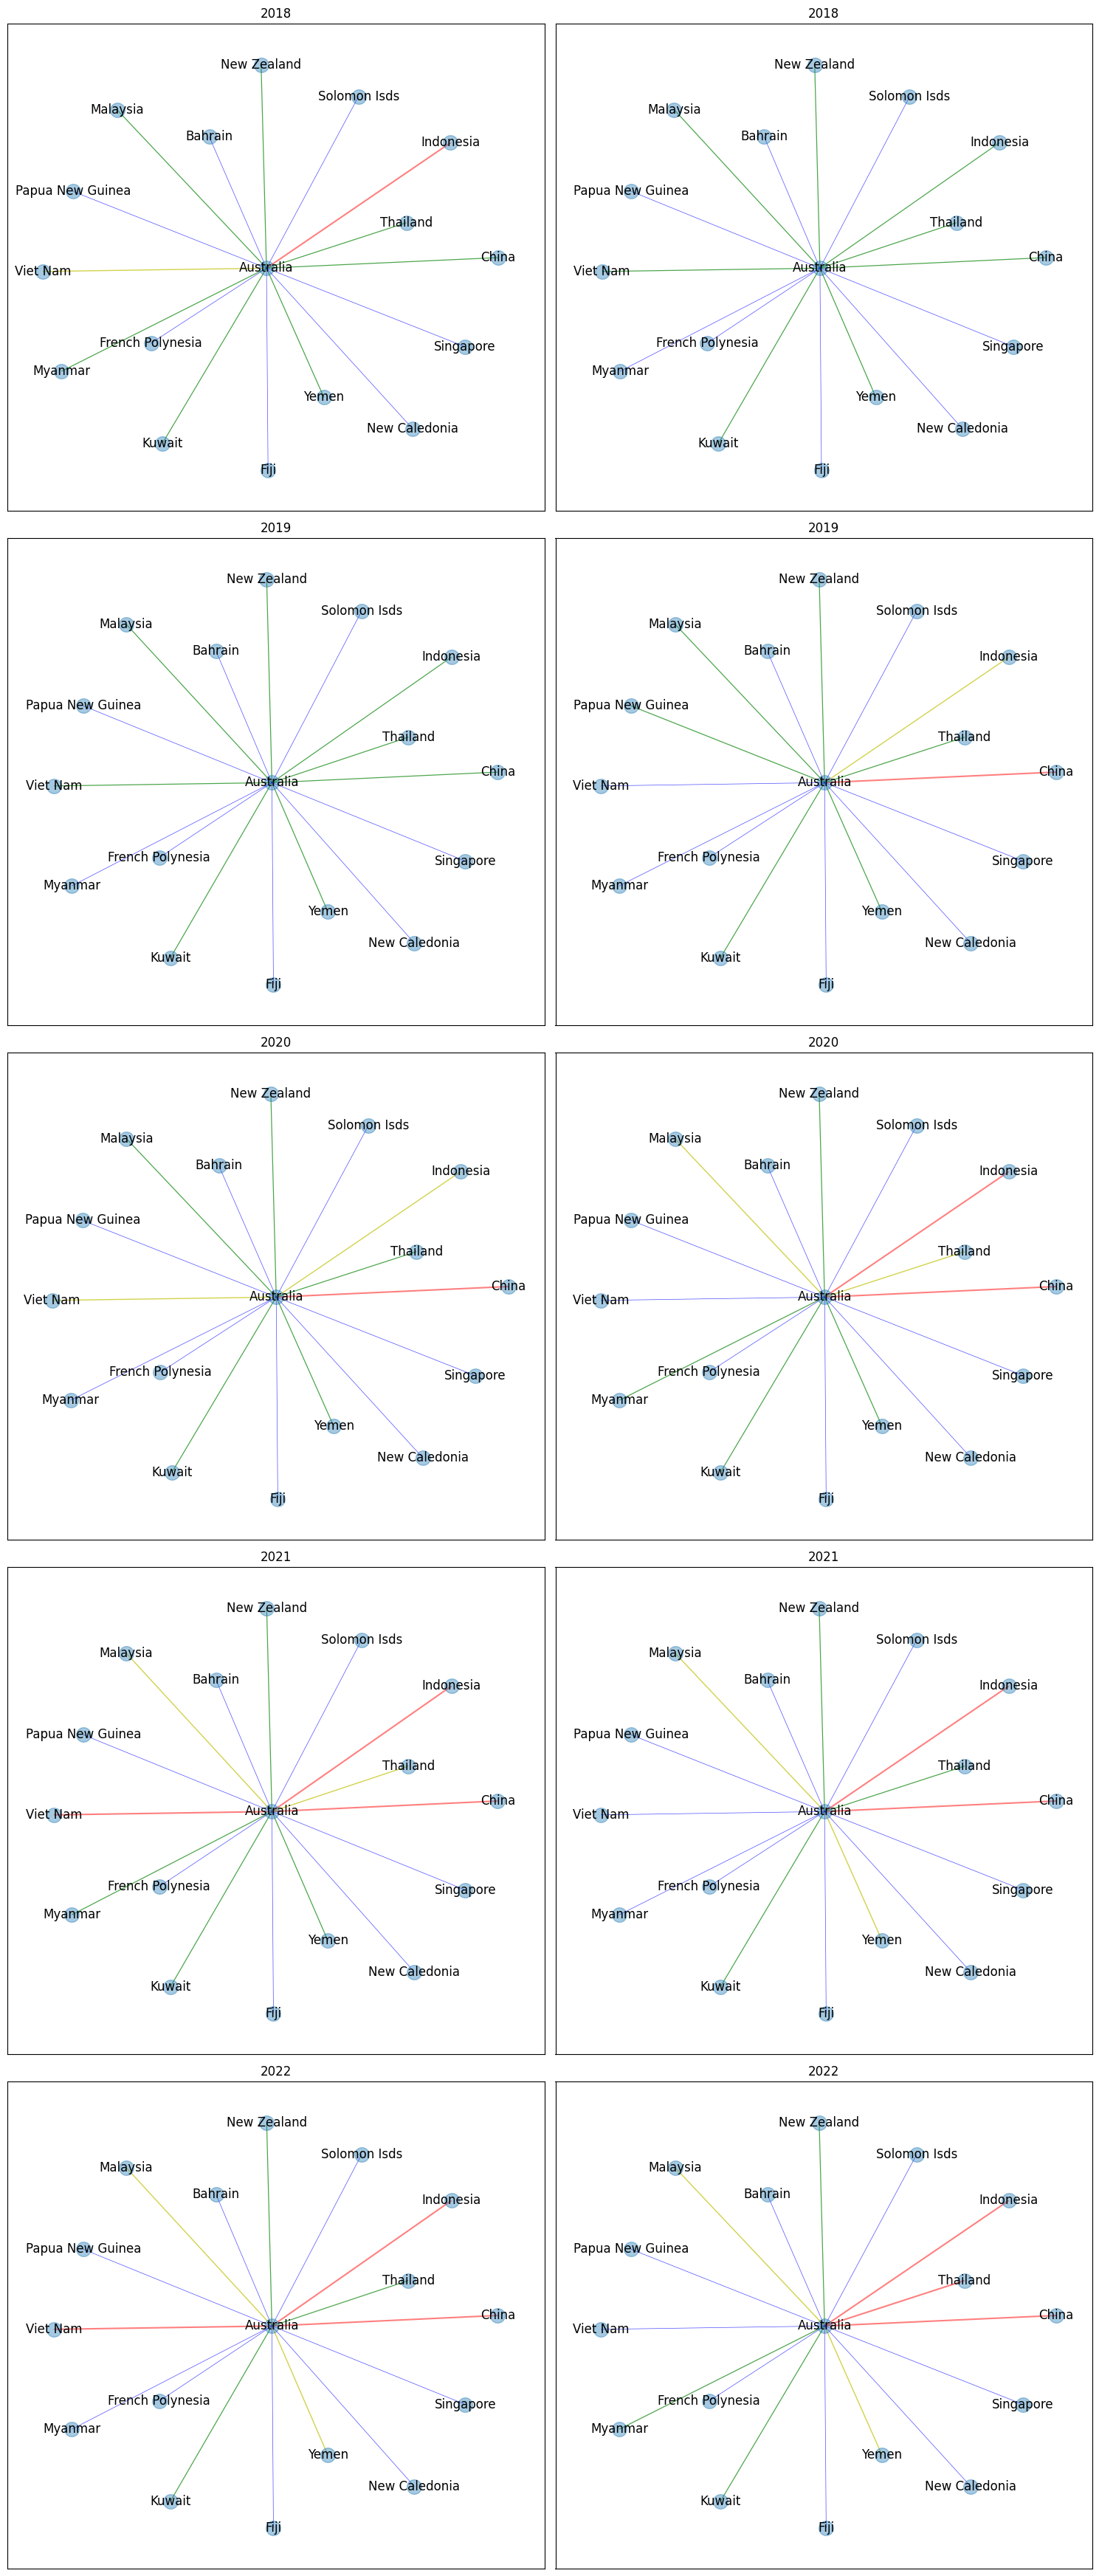

In [23]:
import matplotlib.pyplot as plt
import networkx as nx

fig, axs = plt.subplots(5,2,figsize=(15, 35))


for n in range(2):
    k = 0
    for t, vals in labeled_output[n]:
        axs[t,n].set_title(t + 2018)
        G = nx.Graph()
        
        for i,j,v in vals:
            i_ = demo_dataset.le.inverse_transform([[int(i)]])[0]
            j_ = demo_dataset.le.inverse_transform([[int(j)]])[0]
            G.add_edge(le.inverse_transform([[i_]])[0][0], le.inverse_transform([[j_]])[0][0], weight= float(v))
            if n == 0:
                result_output_table.append([t + 2018,le.inverse_transform([[i_]])[0][0], le.inverse_transform([[j_]])[0][0], float(v)* features_max[0]])                        
            else:
                result_output_table[k] += [float(v)* features_max[0]]  
            k += 1    
        
        elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0.2]
        ealarge = [(u, v) for (u, v, d) in G.edges(data=True) if ((d["weight"] > 0.15) and (d["weight"] <= 0.2))]
        emed = [(u, v) for (u, v, d) in G.edges(data=True) if ((d["weight"] > 0.05) and (d["weight"] <= 0.15))]
        esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.05]
    
    
        if len(elarge + esmall+emed+ealarge) > 0:
            layout = nx.spring_layout(G, seed=7,weight=None)
            #nx.draw(G, layout)
            nx.draw_networkx_nodes(G, layout, node_size=200,alpha=0.4,ax=axs[t,n])
        
            # edges
            nx.draw_networkx_edges(G, layout, edgelist=elarge, width=1.5,alpha=0.5,edge_color="r",ax=axs[t,n])
            nx.draw_networkx_edges(
                G, layout, edgelist=ealarge, width=1.0, alpha=0.7, edge_color="y",ax=axs[t,n]
            )           
            nx.draw_networkx_edges(
                G, layout, edgelist=emed, width=0.9, alpha=0.7, edge_color="g",ax=axs[t,n]
            )        
            nx.draw_networkx_edges(
                G, layout, edgelist=esmall, width=0.5, alpha=0.7, edge_color="b",ax=axs[t,n]
            )
            
            # node labels
            nx.draw_networkx_labels(G, layout, font_size=12, font_family="sans-serif",ax=axs[t,n])
            # edge weight labels
            #edge_labels = nx.get_edge_attributes(G, "weight")
            #nx.draw_networkx_edge_labels(G, layout, edge_labels,font_size=6)
plt.tight_layout()
plt.savefig("constrained_model2.png")        
plt.show()       

In [25]:
pd.set_option('display.max_rows', 500)

pd.DataFrame(result_output_table,columns=["Year","Exporter","Importer","Unconstrained","Constrained: Au->Ind"]).to_csv("trade_model2.csv",sep=";")